In [1]:
import pickle
import numpy as np
import pandas as pd
import torch
from torch import nn
import random
from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import tqdm
import os
import matplotlib.pyplot as plt
from collections import defaultdict
import scipy
import yfinance as yf
from empyrical import sharpe_ratio
from src.features import DeepMomentumFeatures, MACDFeatures, DatetimeFeatures, DefaultFeatureCreator
from src.utils import TrainValTestSplitter
from src.models import *

In [2]:
torch.__version__

'2.0.0'

In [3]:
with open('sectors_dict.pickle', 'rb') as f:
    sectors = pickle.load(f)

In [4]:
SEED = 42
N_ASSETS_PER_SECTOR = 5
LENGTH_THRESHOLD = 3000
DATASET_DIRNAME = 'yf_data'
USE_ADJUSTED_CLOSE = True

In [5]:
np.random.seed(SEED)
all_dfs = []
all_used_assets = []
for current_sector in sectors.keys():
    dfs = []
    assets = []
    for asset in sectors[current_sector]:
        df = pd.read_csv(os.path.join(DATASET_DIRNAME, f'{current_sector}', f'{asset}.csv'))
        # use only stocks with long enough history
        if len(df) > LENGTH_THRESHOLD:
            df['Date'] = pd.to_datetime(df['Date'])
            
            close_col = 'Adj Close' if USE_ADJUSTED_CLOSE else 'Close'
            
            cols = ['Date', 'Open', 'High', 'Low', close_col, 'Volume']
            
            df = df[cols]
            
            df.columns = ['Date'] + ['{}_{}'.format(asset, name) for name in \
                                     ['open', 'high', 'low', 'close', 'volume']]
            dfs.append(df)
            assets.append(asset)

    df = dfs[0]
    for i in range(1, len(dfs)):
        df = pd.merge(df, dfs[i], left_on='Date', right_on='Date', how='inner')

    used_assets = np.random.choice(assets, N_ASSETS_PER_SECTOR, replace=False)
    df = df[['Date'] + [name for name in df.columns[1:] if name.split('_')[0] in used_assets]]
    all_dfs.append(df)
    all_used_assets.extend(list(used_assets))

df = all_dfs[0]
for i in range(1, len(all_dfs)):
    df = pd.merge(df, all_dfs[i], left_on='Date', right_on='Date', how='inner')
df = df.set_index(df['Date'])
print('loaded dataframe shape', df.shape)

loaded dataframe shape (3068, 276)


In [6]:
df

Date  ATVI_open  ATVI_high   ATVI_low  ATVI_close  \
Date                                                                 
2011-06-24 2011-06-24  11.490000  11.490000  11.250000   10.189775   
2011-06-27 2011-06-27  11.270000  11.490000  11.210000   10.271007   
2011-06-28 2011-06-28  11.390000  11.600000  11.330000   10.460541   
2011-06-29 2011-06-29  11.620000  11.760000  11.500000   10.550797   
2011-06-30 2011-06-30  11.740000  11.790000  11.670000   10.541772   
...               ...        ...        ...        ...         ...   
2023-08-28 2023-08-28  91.809998  92.010002  91.750000   91.769997   
2023-08-29 2023-08-29  91.750000  92.099998  91.750000   91.980003   
2023-08-30 2023-08-30  91.879997  92.040001  91.750000   91.980003   
2023-08-31 2023-08-31  91.879997  92.059998  91.870003   91.989998   
2023-09-01 2023-09-01  92.050003  92.199997  91.949997   92.040001   

            ATVI_volume  GOOGL_open  GOOGL_high   GOOGL_low  GOOGL_close  ...  \
Date                                                                      ...   
2011-06-24     16441800   12.029029   12.030781   11.837337    11.883884  ...   
2011-06-27      4798600   11.861862   12.222222   11.851852    12.082082  ...   
2011-06-28      6695400   12.112613   12.417668   12.112613    12.353604  ...   
2011-06-29      6435300   12.425926   12.518769   12.321822    12.451702  ...   
2011-06-30      6501800   12.562312   12.679429   12.550050    12.672172  ...   
...                 ...         ...         ...         ...          ...  ...   
2023-08-28      5527200  131.309998  132.539993  130.139999   131.009995  ...   
2023-08-29      5667900  132.240005  136.570007  132.240005   134.570007  ...   
2023-08-30      5359700  134.779999  136.279999  134.070007   135.880005  ...   
2023-08-31      6676500  136.009995  138.000000  135.789993   136.169998  ...   
2023-09-01      4605700  137.460007  137.460007  134.850006   135.660004  ...   

             SRE_open   SRE_high    SRE_low  SRE_close  SRE_volume   XEL_open  \
Date                                                                            
2011-06-24  26.000000  26.195000  25.885000  12.255710     3270600  23.969999   
2011-06-27  25.969999  26.195000  25.959999  12.338344     2036000  24.120001   
2011-06-28  26.190001  26.235001  26.010000  12.293487     2512800  24.320000   
2011-06-29  26.139999  26.205000  25.985001  12.347787     2127600  24.459999   
2011-06-30  26.260000  26.459999  26.049999  12.484720     2234200  24.469999   
...               ...        ...        ...        ...         ...        ...   
2023-08-28  71.660004  72.080002  71.330002  71.559998     1600500  57.860001   
2023-08-29  71.739998  72.089996  71.199997  71.709999     1777400  57.779999   
2023-08-30  71.510002  71.820000  70.580002  70.849998     1938700  57.880001   
2023-08-31  71.099998  71.410004  70.150002  70.220001     3408400  57.959999   
2023-09-01  70.730003  70.910004  69.510002  70.059998     1804000  57.490002   

             XEL_high    XEL_low  XEL_close  XEL_volume  
Date                                                     
2011-06-24  24.180000  23.969999  16.178503     2162800  
2011-06-27  24.290001  24.100000  16.306477     1412500  
2011-06-28  24.459999  24.190001  16.420980     1720100  
2011-06-29  24.459999  24.350000  16.420980     2013700  
2011-06-30  24.469999  24.230000  16.367092     4290900  
...               ...        ...        ...         ...  
2023-08-28  58.150002  57.650002  57.849998     3982200  
2023-08-29  58.340000  57.509998  57.950001     4614900  
2023-08-30  58.240002  57.419998  57.680000     2583500  
2023-08-31  58.080002  57.110001  57.130001     3983700  
2023-09-01  57.529999  56.080002  56.509998     2848100  

[3068 rows x 276 columns]

In [7]:
USE_DATETIME_FEATURES = False

In [8]:
used_features = [DeepMomentumFeatures, MACDFeatures]
features_configs = [{}, {}]
if USE_DATETIME_FEATURES:
    used_features.append(DatetimeFeatures)
    features_configs.append({})

fc = DefaultFeatureCreator(df, all_used_assets, used_features, features_configs)

features = fc.create_features()


In [9]:
BAD_VALUES_THRESHOLD = 10000
for key in features.keys():
    assert features[key].isnull().sum().sum() == 0
    assert features[key].max().max() < BAD_VALUES_THRESHOLD
    assert features[key].min().min() > -BAD_VALUES_THRESHOLD

In [10]:
cols_to_use = ['norm_daily_return',
               'norm_monthly_return',
               'norm_quarterly_return',
               'norm_biannual_return',
               'norm_annual_return',
               'macd_8_24',
               'macd_16_48',
               'macd_32_96']

if USE_DATETIME_FEATURES:
    datetime_cols = ['day_of_week', 'day_of_month', 'month_of_year']
else:
    datetime_cols = []

In [11]:
for asset in features.keys():
    features[asset]['asset'] = asset

In [12]:
from torch.utils.data import Dataset
class TrainDataset(Dataset):
    
    def __init__(self, df, history_size, cols_to_use, target_col, vol_col):
        self._df = df
        self._history_size = history_size
        self._cols_to_use = cols_to_use
        self._target_col = target_col
        self._vol_col = vol_col
    
    
    def __len__(self):
        return max(len(self._df) - self._history_size, 0)
    
    
    def __getitem__(self, idx):
        
        X = self._df.iloc[idx:idx+self._history_size][self._cols_to_use].values
        
        y = self._df.iloc[idx:idx+self._history_size][self._target_col].values[..., np.newaxis]
    
        vol = self._df.iloc[idx:idx+self._history_size][self._vol_col].values[..., np.newaxis]
        
        asset_change = self._df.iloc[idx:idx+self._history_size]['label_diff'].values
        
        mask = np.ones_like(y)
        
        nonzero_entry = np.argwhere(asset_change != 0).ravel()
        if len(nonzero_entry) != 0:
            mask[:, :nonzero_entry[0]] = 0
        
        return X, y, mask, vol

In [13]:
class EvalDataset(Dataset):
    
    def __init__(self, data, history_size, cols_to_use, target_col, vol_col):
        self._keys = list(data.keys())
        self._data = data
        self._history_size = history_size
        self._cols_to_use = cols_to_use
        self._target_col = target_col
        self._vol_col = vol_col
        
        
    def __len__(self,):
        return max(len(self._data[self._keys[0]]) - self._history_size, 0)
    
    
    def __getitem__(self, idx):
        
        X, y, vol = {}, {}, {}
        for key in self._keys:
            X[key] = self._data[key].iloc[idx:idx+self._history_size][self._cols_to_use].values
            y[key] = self._data[key].iloc[idx:idx+self._history_size][self._target_col].values[..., np.newaxis]
    
            vol[key] = self._data[key].iloc[idx:idx+self._history_size][self._vol_col].values[..., np.newaxis]
            
        return X, y, vol

In [14]:
from copy import deepcopy
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import abc


def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

    
class TrainValTestSplitter(abc.ABC):
    
    @abc.abstractmethod
    def split(self, start, val_delta, test_delta, seed):
        pass
    

class UnivariateTrainValTestSplitter(TrainValTestSplitter):
    def __init__(self, data, cols, datetime_cols, target_col, orig_returns_col, vol_col,
                 timesteps=63, scaling=None, batch_size=256):
        self._data = deepcopy(data)
        self._cols = cols
        self._datetime_cols = datetime_cols
        self._target_col = target_col
        self._orig_returns_col = orig_returns_col
        self._vol_col = vol_col
        self._scaling = scaling
        self._scalers = {}
        self._timesteps = timesteps
        self._batch_size= batch_size
        
        assert len(datetime_cols) == 0
        assert self._target_col not in self._cols
        assert self._orig_returns_col not in self._cols
       # assert self._vol_col not in self._cols
        
        
    def split(self, start, val_delta, test_delta, seed):        
        
        offset_delta = pd.Timedelta('1day')
        
        test_datetimes = []
        datetime_features_created = False
        
        for key in self._data.keys():
            train_val_test = self._data[key].loc[:start+val_delta+test_delta]
            
            # optionally scale features
            if self._scaling is not None:
                if self._scaling == 'minmax':
                    scaler = MinMaxScaler().fit(train_val_test.loc[:start, self._cols])
                elif self._scaling == 'standard':
                    scaler = StandardScaler().fit(train_val_test.loc[:start, self._cols])
                
                else:
                    raise NotImplementedError
                
                self._scalers[(start, key)] = scaler

                train_val_test.loc[:, self._cols] = scaler.transform(train_val_test.loc[:, self._cols])
        
        concat_train_df = []
        val_data, test_data = {}, {}
        test_datetimes = []
        for key in self._data.keys():
        
            df = self._data[key]
            df[self._cols + [self._target_col, self._vol_col]] =\
                df[self._cols + [self._target_col, self._vol_col]].astype(np.float32)
            
            train_df_ = df.loc[:start]
            val_df_ = df.loc[start+offset_delta:start+val_delta]
            test_df_ = df.loc[start+val_delta+offset_delta:start+val_delta+test_delta]
            
            # to avoid data overlapping
            train_df = train_df_.iloc[:-self._timesteps]
            val_df = pd.concat([train_df_.iloc[-self._timesteps:], val_df_.iloc[:-self._timesteps]])
            test_df = pd.concat([val_df_.iloc[-self._timesteps:], test_df_])
            
            test_datetime = test_df.index[self._timesteps:]
            
            concat_train_df.append(train_df)
            val_data[key] = val_df
            test_data[key] = test_df
            test_datetimes.append(test_datetime)
        
        #check alignment by time axis

        for i in range(1, len(test_datetimes)):
            assert np.all((test_datetimes[i] - test_datetimes[0]) == pd.Timedelta(0))
            
        concat_train_df = pd.concat(concat_train_df)
        
        # use asset name info to avoid overlapping of different assets features during training
        concat_train_df['label'] = LabelEncoder().fit_transform(concat_train_df['asset'].values)
        concat_train_df['label_diff'] = concat_train_df['label'].diff().bfill()

        train_dataset = TrainDataset(concat_train_df, self._timesteps, self._cols, self._target_col, self._vol_col)
        val_dataset = EvalDataset(val_data, self._timesteps, self._cols, self._target_col, self._vol_col)
        test_dataset = EvalDataset(test_data, self._timesteps, self._cols, self._target_col, self._vol_col)
        
        g = torch.Generator()
        g.manual_seed(seed)

        train_loader = DataLoader(train_dataset,
                                  shuffle=True, batch_size=self._batch_size,
                                 worker_init_fn=seed_worker, generator=g)
        val_loader = DataLoader(val_dataset,
                                shuffle=False, batch_size=self._batch_size)
        test_loader = DataLoader(test_dataset,
                                 shuffle=False, batch_size=self._batch_size)
        
        return train_loader, val_loader, test_loader, test_datetimes[0]

In [15]:
MODEL_MAPPING = {'lstm': LSTMnet,
                 'conv': TCN,}

In [16]:
scaling = None #'standard', 'minmax'
history_size = 21
val_delta = pd.Timedelta('365days')
test_delta = pd.Timedelta('365days')
date_range = pd.date_range('2017-01-01', '2023-12-31', freq='365d')
model_type = 'conv' 
model_params = {}
apply_turnover_reg = False
apply_l1_reg = False
weight_decay = 1e-5
lr = 1e-3
decay_steps = 10
decay_gamma = 0.75
early_stopping_rounds = 15
n_epochs = 200
device = 'cpu'
target_vol = 0.15 #measure for turnover evaluation
basis_points = [0, 1, 5, 10] #coefficients for turnover evaluation

In [17]:
def _set_seed(seed):

    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    #torch.backends.cudnn.deterministic = True
    #torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

In [18]:
def sharpe_loss(preds, returns, mask=None):
    R = preds*returns
    if mask is not None:
        R = R*mask

    R_sum = torch.mean(R, dim=(1, 0))
    R_sum_sq = R_sum**2
    R_sq_sum = torch.mean(R**2, dim=(1, 0))
    
    sharpe = -1*252**0.5*R_sum/torch.sqrt(R_sq_sum - R_sum_sq + 1e-9)

    sharpe = torch.mean(sharpe)
    
    return sharpe

In [19]:
def reg_turnover(preds, vol, mask=None, alpha=1, is_l1=True, target_vol=0.15, C=5):
    
    if mask is not None:
        preds = preds*mask
        vol = vol*mask
    
    vol = vol*252**0.5
    
    y = preds/(vol + 1e-12)
    y = torch.diff(y, dim=1)
    
    if is_l1:
        y = torch.abs(y)
    else:
        y = y**2
        
        
    l = alpha*C*target_vol*torch.mean(y)    
    
    return l

Random seed set as 42


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Iter:  0
Train loss:  -1.081
Val loss:  -0.471
Validation Sharpe Ratio
C:  0 SR:  2.265
C:  1 SR:  1.76
C:  5 SR:  -0.262
C:  10 SR:  -2.788
Epochs till end:  14



  0%|          | 0/240 [00:00<?, ?it/s]

Iter:  1
Train loss:  -3.326
Val loss:  -0.44
Validation Sharpe Ratio
C:  0 SR:  2.744
C:  1 SR:  2.102
C:  5 SR:  -0.456
C:  10 SR:  -3.632
Epochs till end:  15



  0%|          | 0/240 [00:00<?, ?it/s]

Iter:  2
Train loss:  -5.021
Val loss:  -0.135
Validation Sharpe Ratio
C:  0 SR:  -0.247
C:  1 SR:  -1.121
C:  5 SR:  -4.612
C:  10 SR:  -8.952
Epochs till end:  14



  0%|          | 0/240 [00:00<?, ?it/s]

Iter:  3
Train loss:  -6.173
Val loss:  -0.2
Validation Sharpe Ratio
C:  0 SR:  0.817
C:  1 SR:  -0.032
C:  5 SR:  -3.433
C:  10 SR:  -7.688
Epochs till end:  13



  0%|          | 0/240 [00:00<?, ?it/s]

Iter:  4
Train loss:  -7.019
Val loss:  -0.108
Validation Sharpe Ratio
C:  0 SR:  0.938
C:  1 SR:  0.075
C:  5 SR:  -3.369
C:  10 SR:  -7.646
Epochs till end:  12



  0%|          | 0/240 [00:00<?, ?it/s]

Iter:  5
Train loss:  -7.691
Val loss:  -0.46
Validation Sharpe Ratio
C:  0 SR:  2.981
C:  1 SR:  2.163
C:  5 SR:  -1.108
C:  10 SR:  -5.176
Epochs till end:  15



  0%|          | 0/240 [00:00<?, ?it/s]

Iter:  6
Train loss:  -8.223
Val loss:  -0.512
Validation Sharpe Ratio
C:  0 SR:  2.776
C:  1 SR:  1.94
C:  5 SR:  -1.409
C:  10 SR:  -5.588
Epochs till end:  14



  0%|          | 0/240 [00:00<?, ?it/s]

Iter:  7
Train loss:  -8.627
Val loss:  -0.355
Validation Sharpe Ratio
C:  0 SR:  2.825
C:  1 SR:  1.984
C:  5 SR:  -1.384
C:  10 SR:  -5.591
Epochs till end:  13



  0%|          | 0/240 [00:00<?, ?it/s]

Iter:  8
Train loss:  -8.944
Val loss:  -0.349
Validation Sharpe Ratio
C:  0 SR:  1.924
C:  1 SR:  1.012
C:  5 SR:  -2.633
C:  10 SR:  -7.168
Epochs till end:  12



  0%|          | 0/240 [00:00<?, ?it/s]

Iter:  9
Train loss:  -9.31
Val loss:  -0.305
Validation Sharpe Ratio
C:  0 SR:  2.401
C:  1 SR:  1.52
C:  5 SR:  -2.012
C:  10 SR:  -6.433
Epochs till end:  11



  0%|          | 0/240 [00:00<?, ?it/s]

Iter:  10
Train loss:  -9.846
Val loss:  -0.28
Validation Sharpe Ratio
C:  0 SR:  1.774
C:  1 SR:  0.837
C:  5 SR:  -2.904
C:  10 SR:  -7.548
Epochs till end:  10



  0%|          | 0/240 [00:00<?, ?it/s]

Iter:  11
Train loss:  -10.104
Val loss:  -0.324
Validation Sharpe Ratio
C:  0 SR:  1.883
C:  1 SR:  0.899
C:  5 SR:  -3.049
C:  10 SR:  -7.994
Epochs till end:  9



  0%|          | 0/240 [00:00<?, ?it/s]

Iter:  12
Train loss:  -10.314
Val loss:  -0.296
Validation Sharpe Ratio
C:  0 SR:  1.859
C:  1 SR:  0.87
C:  5 SR:  -3.089
C:  10 SR:  -8.029
Epochs till end:  8



  0%|          | 0/240 [00:00<?, ?it/s]

Iter:  13
Train loss:  -10.493
Val loss:  -0.366
Validation Sharpe Ratio
C:  0 SR:  2.532
C:  1 SR:  1.543
C:  5 SR:  -2.414
C:  10 SR:  -7.358
Epochs till end:  7



  0%|          | 0/240 [00:00<?, ?it/s]

Iter:  14
Train loss:  -10.641
Val loss:  -0.313
Validation Sharpe Ratio
C:  0 SR:  2.933
C:  1 SR:  1.927
C:  5 SR:  -2.108
C:  10 SR:  -7.168
Epochs till end:  6



  0%|          | 0/240 [00:00<?, ?it/s]

Iter:  15
Train loss:  -10.816
Val loss:  -0.347
Validation Sharpe Ratio
C:  0 SR:  2.247
C:  1 SR:  1.251
C:  5 SR:  -2.721
C:  10 SR:  -7.646
Epochs till end:  5



  0%|          | 0/240 [00:00<?, ?it/s]

Iter:  16
Train loss:  -10.961
Val loss:  -0.302
Validation Sharpe Ratio
C:  0 SR:  1.594
C:  1 SR:  0.641
C:  5 SR:  -3.174
C:  10 SR:  -7.943
Epochs till end:  4



  0%|          | 0/240 [00:00<?, ?it/s]

Iter:  17
Train loss:  -11.082
Val loss:  -0.291
Validation Sharpe Ratio
C:  0 SR:  1.884
C:  1 SR:  0.917
C:  5 SR:  -2.962
C:  10 SR:  -7.821
Epochs till end:  3



  0%|          | 0/240 [00:00<?, ?it/s]

Iter:  18
Train loss:  -11.241
Val loss:  -0.494
Validation Sharpe Ratio
C:  0 SR:  3.285
C:  1 SR:  2.428
C:  5 SR:  -0.997
C:  10 SR:  -5.259
Epochs till end:  15



  0%|          | 0/240 [00:00<?, ?it/s]

Iter:  19
Train loss:  -11.355
Val loss:  -0.3
Validation Sharpe Ratio
C:  0 SR:  1.872
C:  1 SR:  0.964
C:  5 SR:  -2.671
C:  10 SR:  -7.209
Epochs till end:  14



  0%|          | 0/240 [00:00<?, ?it/s]

Iter:  20
Train loss:  -11.719
Val loss:  -0.441
Validation Sharpe Ratio
C:  0 SR:  2.939
C:  1 SR:  2.052
C:  5 SR:  -1.492
C:  10 SR:  -5.909
Epochs till end:  13



  0%|          | 0/240 [00:00<?, ?it/s]

Iter:  21
Train loss:  -11.814
Val loss:  -0.406
Validation Sharpe Ratio
C:  0 SR:  3.295
C:  1 SR:  2.322
C:  5 SR:  -1.57
C:  10 SR:  -6.423
Epochs till end:  15



  0%|          | 0/240 [00:00<?, ?it/s]

Iter:  22
Train loss:  -11.879
Val loss:  -0.408
Validation Sharpe Ratio
C:  0 SR:  3.559
C:  1 SR:  2.584
C:  5 SR:  -1.323
C:  10 SR:  -6.215
Epochs till end:  15



  0%|          | 0/240 [00:00<?, ?it/s]

Iter:  23
Train loss:  -11.977
Val loss:  -0.372
Validation Sharpe Ratio
C:  0 SR:  2.683
C:  1 SR:  1.781
C:  5 SR:  -1.836
C:  10 SR:  -6.357
Epochs till end:  14



  0%|          | 0/240 [00:00<?, ?it/s]

Iter:  24
Train loss:  -12.078
Val loss:  -0.354
Validation Sharpe Ratio
C:  0 SR:  2.483
C:  1 SR:  1.527
C:  5 SR:  -2.301
C:  10 SR:  -7.08
Epochs till end:  13



  0%|          | 0/240 [00:00<?, ?it/s]

Iter:  25
Train loss:  -12.123
Val loss:  -0.31
Validation Sharpe Ratio
C:  0 SR:  2.198
C:  1 SR:  1.244
C:  5 SR:  -2.587
C:  10 SR:  -7.391
Epochs till end:  12



  0%|          | 0/240 [00:00<?, ?it/s]

Iter:  26
Train loss:  -12.22
Val loss:  -0.224
Validation Sharpe Ratio
C:  0 SR:  1.873
C:  1 SR:  0.943
C:  5 SR:  -2.788
C:  10 SR:  -7.463
Epochs till end:  11



  0%|          | 0/240 [00:00<?, ?it/s]

Iter:  27
Train loss:  -12.277
Val loss:  -0.292
Validation Sharpe Ratio
C:  0 SR:  3.116
C:  1 SR:  2.119
C:  5 SR:  -1.86
C:  10 SR:  -6.802
Epochs till end:  10



  0%|          | 0/240 [00:00<?, ?it/s]

Iter:  28
Train loss:  -12.395
Val loss:  -0.267
Validation Sharpe Ratio
C:  0 SR:  2.325
C:  1 SR:  1.276
C:  5 SR:  -2.919
C:  10 SR:  -8.148
Epochs till end:  9



  0%|          | 0/240 [00:00<?, ?it/s]

Iter:  29
Train loss:  -12.434
Val loss:  -0.261
Validation Sharpe Ratio
C:  0 SR:  2.181
C:  1 SR:  1.207
C:  5 SR:  -2.683
C:  10 SR:  -7.521
Epochs till end:  8



  0%|          | 0/240 [00:00<?, ?it/s]

Iter:  30
Train loss:  -12.699
Val loss:  -0.241
Validation Sharpe Ratio
C:  0 SR:  2.142
C:  1 SR:  1.121
C:  5 SR:  -2.964
C:  10 SR:  -8.055
Epochs till end:  7



  0%|          | 0/240 [00:00<?, ?it/s]

Iter:  31
Train loss:  -12.744
Val loss:  -0.38
Validation Sharpe Ratio
C:  0 SR:  3.253
C:  1 SR:  2.237
C:  5 SR:  -1.822
C:  10 SR:  -6.864
Epochs till end:  6



  0%|          | 0/240 [00:00<?, ?it/s]

Iter:  32
Train loss:  -12.825
Val loss:  -0.284
Validation Sharpe Ratio
C:  0 SR:  2.681
C:  1 SR:  1.632
C:  5 SR:  -2.566
C:  10 SR:  -7.795
Epochs till end:  5



  0%|          | 0/240 [00:00<?, ?it/s]

Iter:  33
Train loss:  -12.86
Val loss:  -0.368
Validation Sharpe Ratio
C:  0 SR:  3.29
C:  1 SR:  2.295
C:  5 SR:  -1.699
C:  10 SR:  -6.715
Epochs till end:  4



  0%|          | 0/240 [00:00<?, ?it/s]

Iter:  34
Train loss:  -12.888
Val loss:  -0.267
Validation Sharpe Ratio
C:  0 SR:  2.555
C:  1 SR:  1.57
C:  5 SR:  -2.383
C:  10 SR:  -7.34
Epochs till end:  3



  0%|          | 0/240 [00:00<?, ?it/s]

Iter:  35
Train loss:  -12.984
Val loss:  -0.304
Validation Sharpe Ratio
C:  0 SR:  2.402
C:  1 SR:  1.445
C:  5 SR:  -2.384
C:  10 SR:  -7.153
Epochs till end:  2



  0%|          | 0/240 [00:00<?, ?it/s]

Iter:  36
Train loss:  -13.001
Val loss:  -0.391
Validation Sharpe Ratio
C:  0 SR:  3.435
C:  1 SR:  2.424
C:  5 SR:  -1.618
C:  10 SR:  -6.65
Epochs till end:  1



  0%|          | 0/240 [00:00<?, ?it/s]

Iter:  37
Train loss:  -13.058
Val loss:  -0.309
Validation Sharpe Ratio
C:  0 SR:  2.516
C:  1 SR:  1.477
C:  5 SR:  -2.674
C:  10 SR:  -7.84
Epochs till end:  0



  0%|          | 0/240 [00:00<?, ?it/s]

Validation dates:  2017-01-01 00:00:00 2018-01-01 00:00:00


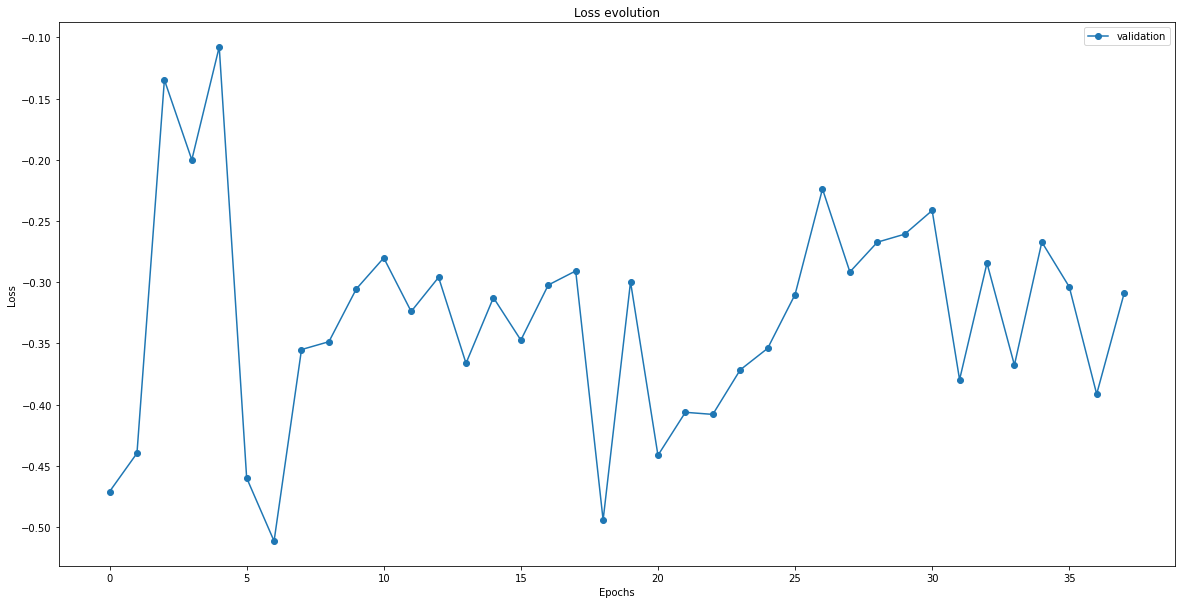

Random seed set as 42


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/294 [00:00<?, ?it/s]

Iter:  0
Train loss:  -0.938
Val loss:  0.1
Validation Sharpe Ratio
C:  0 SR:  -0.344
C:  1 SR:  -0.513
C:  5 SR:  -1.189
C:  10 SR:  -2.034
Epochs till end:  14



  0%|          | 0/294 [00:00<?, ?it/s]

Iter:  1
Train loss:  -2.749
Val loss:  0.03
Validation Sharpe Ratio
C:  0 SR:  -0.585
C:  1 SR:  -0.969
C:  5 SR:  -2.509
C:  10 SR:  -4.436
Epochs till end:  15



  0%|          | 0/294 [00:00<?, ?it/s]

Iter:  2
Train loss:  -4.518
Val loss:  -0.054
Validation Sharpe Ratio
C:  0 SR:  -0.042
C:  1 SR:  -0.574
C:  5 SR:  -2.698
C:  10 SR:  -5.349
Epochs till end:  15



  0%|          | 0/294 [00:00<?, ?it/s]

Iter:  3
Train loss:  -5.667
Val loss:  -0.065
Validation Sharpe Ratio
C:  0 SR:  -0.167
C:  1 SR:  -0.698
C:  5 SR:  -2.821
C:  10 SR:  -5.464
Epochs till end:  14



  0%|          | 0/294 [00:00<?, ?it/s]

Iter:  4
Train loss:  -6.569
Val loss:  -0.123
Validation Sharpe Ratio
C:  0 SR:  0.047
C:  1 SR:  -0.538
C:  5 SR:  -2.866
C:  10 SR:  -5.741
Epochs till end:  15



  0%|          | 0/294 [00:00<?, ?it/s]

Iter:  5
Train loss:  -7.23
Val loss:  -0.045
Validation Sharpe Ratio
C:  0 SR:  0.123
C:  1 SR:  -0.338
C:  5 SR:  -2.173
C:  10 SR:  -4.453
Epochs till end:  15



  0%|          | 0/294 [00:00<?, ?it/s]

Iter:  6
Train loss:  -7.77
Val loss:  -0.107
Validation Sharpe Ratio
C:  0 SR:  0.617
C:  1 SR:  0.134
C:  5 SR:  -1.793
C:  10 SR:  -4.185
Epochs till end:  15



  0%|          | 0/294 [00:00<?, ?it/s]

Iter:  7
Train loss:  -8.248
Val loss:  -0.118
Validation Sharpe Ratio
C:  0 SR:  0.746
C:  1 SR:  0.223
C:  5 SR:  -1.857
C:  10 SR:  -4.432
Epochs till end:  15



  0%|          | 0/294 [00:00<?, ?it/s]

Iter:  8
Train loss:  -8.583
Val loss:  -0.149
Validation Sharpe Ratio
C:  0 SR:  1.088
C:  1 SR:  0.455
C:  5 SR:  -2.063
C:  10 SR:  -5.172
Epochs till end:  15



  0%|          | 0/294 [00:00<?, ?it/s]

Iter:  9
Train loss:  -8.942
Val loss:  -0.073
Validation Sharpe Ratio
C:  0 SR:  0.13
C:  1 SR:  -0.57
C:  5 SR:  -3.363
C:  10 SR:  -6.837
Epochs till end:  14



  0%|          | 0/294 [00:00<?, ?it/s]

Iter:  10
Train loss:  -9.457
Val loss:  -0.072
Validation Sharpe Ratio
C:  0 SR:  0.052
C:  1 SR:  -0.388
C:  5 SR:  -2.148
C:  10 SR:  -4.339
Epochs till end:  13



  0%|          | 0/294 [00:00<?, ?it/s]

Iter:  11
Train loss:  -9.698
Val loss:  -0.079
Validation Sharpe Ratio
C:  0 SR:  0.506
C:  1 SR:  -0.142
C:  5 SR:  -2.726
C:  10 SR:  -5.931
Epochs till end:  12



  0%|          | 0/294 [00:00<?, ?it/s]

Iter:  12
Train loss:  -9.898
Val loss:  -0.033
Validation Sharpe Ratio
C:  0 SR:  0.051
C:  1 SR:  -0.506
C:  5 SR:  -2.726
C:  10 SR:  -5.487
Epochs till end:  11



  0%|          | 0/294 [00:00<?, ?it/s]

Iter:  13
Train loss:  -10.04
Val loss:  0.001
Validation Sharpe Ratio
C:  0 SR:  -0.554
C:  1 SR:  -1.182
C:  5 SR:  -3.681
C:  10 SR:  -6.776
Epochs till end:  10



  0%|          | 0/294 [00:00<?, ?it/s]

Iter:  14
Train loss:  -10.251
Val loss:  -0.004
Validation Sharpe Ratio
C:  0 SR:  -0.207
C:  1 SR:  -0.857
C:  5 SR:  -3.443
C:  10 SR:  -6.642
Epochs till end:  9



  0%|          | 0/294 [00:00<?, ?it/s]

Iter:  15
Train loss:  -10.349
Val loss:  0.071
Validation Sharpe Ratio
C:  0 SR:  -0.754
C:  1 SR:  -1.377
C:  5 SR:  -3.863
C:  10 SR:  -6.946
Epochs till end:  8



  0%|          | 0/294 [00:00<?, ?it/s]

Iter:  16
Train loss:  -10.508
Val loss:  -0.045
Validation Sharpe Ratio
C:  0 SR:  0.042
C:  1 SR:  -0.562
C:  5 SR:  -2.969
C:  10 SR:  -5.95
Epochs till end:  7



  0%|          | 0/294 [00:00<?, ?it/s]

Iter:  17
Train loss:  -10.614
Val loss:  0.011
Validation Sharpe Ratio
C:  0 SR:  0.239
C:  1 SR:  -0.482
C:  5 SR:  -3.364
C:  10 SR:  -6.95
Epochs till end:  6



  0%|          | 0/294 [00:00<?, ?it/s]

Iter:  18
Train loss:  -10.737
Val loss:  0.061
Validation Sharpe Ratio
C:  0 SR:  -0.896
C:  1 SR:  -1.409
C:  5 SR:  -3.461
C:  10 SR:  -6.021
Epochs till end:  5



  0%|          | 0/294 [00:00<?, ?it/s]

Iter:  19
Train loss:  -10.844
Val loss:  0.067
Validation Sharpe Ratio
C:  0 SR:  -1.021
C:  1 SR:  -1.677
C:  5 SR:  -4.293
C:  10 SR:  -7.541
Epochs till end:  4



  0%|          | 0/294 [00:00<?, ?it/s]

Iter:  20
Train loss:  -11.182
Val loss:  0.047
Validation Sharpe Ratio
C:  0 SR:  -0.924
C:  1 SR:  -1.58
C:  5 SR:  -4.198
C:  10 SR:  -7.451
Epochs till end:  3



  0%|          | 0/294 [00:00<?, ?it/s]

Iter:  21
Train loss:  -11.294
Val loss:  -0.015
Validation Sharpe Ratio
C:  0 SR:  -0.295
C:  1 SR:  -1.046
C:  5 SR:  -4.038
C:  10 SR:  -7.745
Epochs till end:  2



  0%|          | 0/294 [00:00<?, ?it/s]

Iter:  22
Train loss:  -11.347
Val loss:  0.041
Validation Sharpe Ratio
C:  0 SR:  -0.167
C:  1 SR:  -0.93
C:  5 SR:  -3.974
C:  10 SR:  -7.743
Epochs till end:  1



  0%|          | 0/294 [00:00<?, ?it/s]

Iter:  23
Train loss:  -11.444
Val loss:  0.041
Validation Sharpe Ratio
C:  0 SR:  -0.472
C:  1 SR:  -1.15
C:  5 SR:  -3.85
C:  10 SR:  -7.195
Epochs till end:  0



  0%|          | 0/294 [00:00<?, ?it/s]

Validation dates:  2018-01-01 00:00:00 2019-01-01 00:00:00


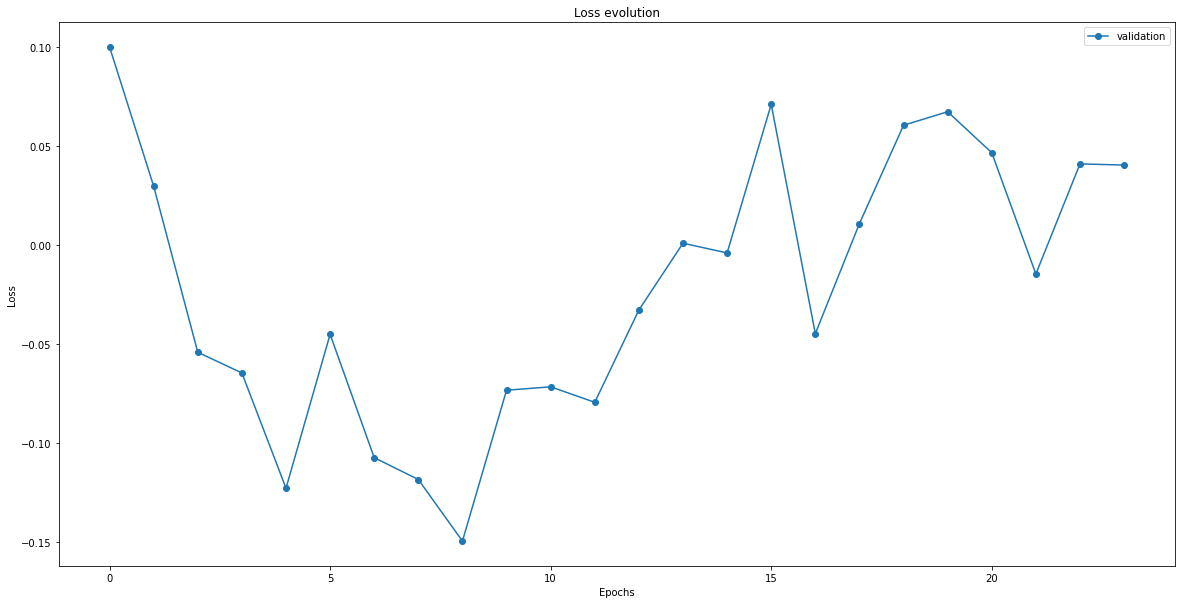

Random seed set as 42


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Iter:  0
Train loss:  -1.01
Val loss:  -0.473
Validation Sharpe Ratio
C:  0 SR:  1.263
C:  1 SR:  0.964
C:  5 SR:  -0.234
C:  10 SR:  -1.729
Epochs till end:  14



  0%|          | 0/348 [00:00<?, ?it/s]

Iter:  1
Train loss:  -2.975
Val loss:  -0.213
Validation Sharpe Ratio
C:  0 SR:  1.633
C:  1 SR:  1.227
C:  5 SR:  -0.39
C:  10 SR:  -2.398
Epochs till end:  15



  0%|          | 0/348 [00:00<?, ?it/s]

Iter:  2
Train loss:  -4.501
Val loss:  -0.116
Validation Sharpe Ratio
C:  0 SR:  1.649
C:  1 SR:  1.173
C:  5 SR:  -0.732
C:  10 SR:  -3.108
Epochs till end:  15



  0%|          | 0/348 [00:00<?, ?it/s]

Iter:  3
Train loss:  -5.577
Val loss:  -0.118
Validation Sharpe Ratio
C:  0 SR:  0.763
C:  1 SR:  0.225
C:  5 SR:  -1.926
C:  10 SR:  -4.612
Epochs till end:  14



  0%|          | 0/348 [00:00<?, ?it/s]

Iter:  4
Train loss:  -6.374
Val loss:  -0.261
Validation Sharpe Ratio
C:  0 SR:  1.927
C:  1 SR:  1.401
C:  5 SR:  -0.701
C:  10 SR:  -3.329
Epochs till end:  15



  0%|          | 0/348 [00:00<?, ?it/s]

Iter:  5
Train loss:  -6.973
Val loss:  0.036
Validation Sharpe Ratio
C:  0 SR:  -0.136
C:  1 SR:  -0.829
C:  5 SR:  -3.604
C:  10 SR:  -7.068
Epochs till end:  14



  0%|          | 0/348 [00:00<?, ?it/s]

Iter:  6
Train loss:  -7.479
Val loss:  -0.158
Validation Sharpe Ratio
C:  0 SR:  1.449
C:  1 SR:  0.811
C:  5 SR:  -1.738
C:  10 SR:  -4.905
Epochs till end:  13



  0%|          | 0/348 [00:00<?, ?it/s]

Iter:  7
Train loss:  -7.877
Val loss:  -0.062
Validation Sharpe Ratio
C:  0 SR:  0.226
C:  1 SR:  -0.493
C:  5 SR:  -3.375
C:  10 SR:  -6.982
Epochs till end:  12



  0%|          | 0/348 [00:00<?, ?it/s]

Iter:  8
Train loss:  -8.197
Val loss:  -0.111
Validation Sharpe Ratio
C:  0 SR:  1.207
C:  1 SR:  0.574
C:  5 SR:  -1.952
C:  10 SR:  -5.092
Epochs till end:  11



  0%|          | 0/348 [00:00<?, ?it/s]

Iter:  9
Train loss:  -8.488
Val loss:  -0.208
Validation Sharpe Ratio
C:  0 SR:  1.926
C:  1 SR:  1.305
C:  5 SR:  -1.175
C:  10 SR:  -4.267
Epochs till end:  10



  0%|          | 0/348 [00:00<?, ?it/s]

Iter:  10
Train loss:  -9.017
Val loss:  -0.226
Validation Sharpe Ratio
C:  0 SR:  2.178
C:  1 SR:  1.517
C:  5 SR:  -1.122
C:  10 SR:  -4.41
Epochs till end:  15



  0%|          | 0/348 [00:00<?, ?it/s]

Iter:  11
Train loss:  -9.249
Val loss:  -0.186
Validation Sharpe Ratio
C:  0 SR:  1.983
C:  1 SR:  1.193
C:  5 SR:  -1.975
C:  10 SR:  -5.941
Epochs till end:  14



  0%|          | 0/348 [00:00<?, ?it/s]

Iter:  12
Train loss:  -9.416
Val loss:  -0.153
Validation Sharpe Ratio
C:  0 SR:  2.32
C:  1 SR:  1.653
C:  5 SR:  -1.02
C:  10 SR:  -4.368
Epochs till end:  15



  0%|          | 0/348 [00:00<?, ?it/s]

Iter:  13
Train loss:  -9.577
Val loss:  -0.032
Validation Sharpe Ratio
C:  0 SR:  0.305
C:  1 SR:  -0.412
C:  5 SR:  -3.284
C:  10 SR:  -6.871
Epochs till end:  14



  0%|          | 0/348 [00:00<?, ?it/s]

Iter:  14
Train loss:  -9.735
Val loss:  -0.047
Validation Sharpe Ratio
C:  0 SR:  1.367
C:  1 SR:  0.594
C:  5 SR:  -2.504
C:  10 SR:  -6.379
Epochs till end:  13



  0%|          | 0/348 [00:00<?, ?it/s]

Iter:  15
Train loss:  -9.876
Val loss:  -0.007
Validation Sharpe Ratio
C:  0 SR:  0.389
C:  1 SR:  -0.343
C:  5 SR:  -3.27
C:  10 SR:  -6.922
Epochs till end:  12



  0%|          | 0/348 [00:00<?, ?it/s]

Iter:  16
Train loss:  -10.012
Val loss:  -0.009
Validation Sharpe Ratio
C:  0 SR:  0.585
C:  1 SR:  -0.204
C:  5 SR:  -3.368
C:  10 SR:  -7.339
Epochs till end:  11



  0%|          | 0/348 [00:00<?, ?it/s]

Iter:  17
Train loss:  -10.136
Val loss:  -0.101
Validation Sharpe Ratio
C:  0 SR:  1.425
C:  1 SR:  0.729
C:  5 SR:  -2.064
C:  10 SR:  -5.565
Epochs till end:  10



  0%|          | 0/348 [00:00<?, ?it/s]

Iter:  18
Train loss:  -10.231
Val loss:  0.021
Validation Sharpe Ratio
C:  0 SR:  0.046
C:  1 SR:  -0.705
C:  5 SR:  -3.725
C:  10 SR:  -7.526
Epochs till end:  9



  0%|          | 0/348 [00:00<?, ?it/s]

Iter:  19
Train loss:  -10.347
Val loss:  -0.037
Validation Sharpe Ratio
C:  0 SR:  1.121
C:  1 SR:  0.387
C:  5 SR:  -2.559
C:  10 SR:  -6.26
Epochs till end:  8



  0%|          | 0/348 [00:00<?, ?it/s]

Iter:  20
Train loss:  -10.66
Val loss:  -0.055
Validation Sharpe Ratio
C:  0 SR:  0.975
C:  1 SR:  0.18
C:  5 SR:  -3.005
C:  10 SR:  -6.986
Epochs till end:  7



  0%|          | 0/348 [00:00<?, ?it/s]

Iter:  21
Train loss:  -10.758
Val loss:  0.039
Validation Sharpe Ratio
C:  0 SR:  0.413
C:  1 SR:  -0.358
C:  5 SR:  -3.451
C:  10 SR:  -7.335
Epochs till end:  6



  0%|          | 0/348 [00:00<?, ?it/s]

Iter:  22
Train loss:  -10.819
Val loss:  -0.003
Validation Sharpe Ratio
C:  0 SR:  0.271
C:  1 SR:  -0.496
C:  5 SR:  -3.573
C:  10 SR:  -7.436
Epochs till end:  5



  0%|          | 0/348 [00:00<?, ?it/s]

Iter:  23
Train loss:  -10.892
Val loss:  -0.069
Validation Sharpe Ratio
C:  0 SR:  0.962
C:  1 SR:  0.239
C:  5 SR:  -2.648
C:  10 SR:  -6.237
Epochs till end:  4



  0%|          | 0/348 [00:00<?, ?it/s]

Iter:  24
Train loss:  -10.963
Val loss:  -0.007
Validation Sharpe Ratio
C:  0 SR:  0.017
C:  1 SR:  -0.777
C:  5 SR:  -3.961
C:  10 SR:  -7.947
Epochs till end:  3



  0%|          | 0/348 [00:00<?, ?it/s]

Iter:  25
Train loss:  -11.01
Val loss:  0.134
Validation Sharpe Ratio
C:  0 SR:  -1.102
C:  1 SR:  -1.945
C:  5 SR:  -5.338
C:  10 SR:  -9.62
Epochs till end:  2



  0%|          | 0/348 [00:00<?, ?it/s]

Iter:  26
Train loss:  -11.106
Val loss:  0.121
Validation Sharpe Ratio
C:  0 SR:  -0.665
C:  1 SR:  -1.448
C:  5 SR:  -4.58
C:  10 SR:  -8.49
Epochs till end:  1



  0%|          | 0/348 [00:00<?, ?it/s]

Iter:  27
Train loss:  -11.136
Val loss:  0.072
Validation Sharpe Ratio
C:  0 SR:  0.207
C:  1 SR:  -0.536
C:  5 SR:  -3.509
C:  10 SR:  -7.221
Epochs till end:  0



  0%|          | 0/348 [00:00<?, ?it/s]

Validation dates:  2019-01-01 00:00:00 2020-01-01 00:00:00


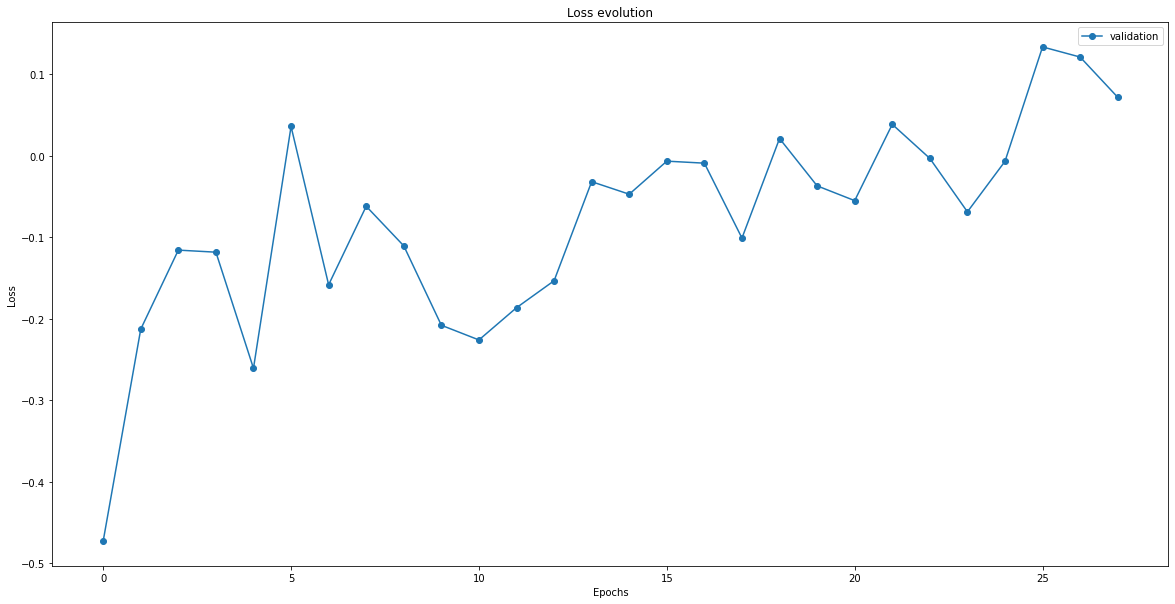

Random seed set as 42


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/402 [00:00<?, ?it/s]

Iter:  0
Train loss:  -1.017
Val loss:  -0.157
Validation Sharpe Ratio
C:  0 SR:  0.026
C:  1 SR:  -0.058
C:  5 SR:  -0.395
C:  10 SR:  -0.816
Epochs till end:  14



  0%|          | 0/402 [00:00<?, ?it/s]

Iter:  1
Train loss:  -2.856
Val loss:  -0.091
Validation Sharpe Ratio
C:  0 SR:  -0.114
C:  1 SR:  -0.236
C:  5 SR:  -0.724
C:  10 SR:  -1.332
Epochs till end:  15



  0%|          | 0/402 [00:00<?, ?it/s]

Iter:  2
Train loss:  -4.401
Val loss:  -0.303
Validation Sharpe Ratio
C:  0 SR:  0.588
C:  1 SR:  0.425
C:  5 SR:  -0.227
C:  10 SR:  -1.038
Epochs till end:  15



  0%|          | 0/402 [00:00<?, ?it/s]

Iter:  3
Train loss:  -5.464
Val loss:  -0.214
Validation Sharpe Ratio
C:  0 SR:  0.506
C:  1 SR:  0.319
C:  5 SR:  -0.427
C:  10 SR:  -1.355
Epochs till end:  14



  0%|          | 0/402 [00:00<?, ?it/s]

Iter:  4
Train loss:  -6.236
Val loss:  -0.232
Validation Sharpe Ratio
C:  0 SR:  1.106
C:  1 SR:  0.862
C:  5 SR:  -0.107
C:  10 SR:  -1.307
Epochs till end:  15



  0%|          | 0/402 [00:00<?, ?it/s]

Iter:  5
Train loss:  -6.837
Val loss:  -0.375
Validation Sharpe Ratio
C:  0 SR:  1.911
C:  1 SR:  1.651
C:  5 SR:  0.612
C:  10 SR:  -0.68
Epochs till end:  15



  0%|          | 0/402 [00:00<?, ?it/s]

Iter:  6
Train loss:  -7.293
Val loss:  -0.273
Validation Sharpe Ratio
C:  0 SR:  0.93
C:  1 SR:  0.658
C:  5 SR:  -0.427
C:  10 SR:  -1.768
Epochs till end:  14



  0%|          | 0/402 [00:00<?, ?it/s]

Iter:  7
Train loss:  -7.707
Val loss:  -0.39
Validation Sharpe Ratio
C:  0 SR:  1.606
C:  1 SR:  1.332
C:  5 SR:  0.244
C:  10 SR:  -1.099
Epochs till end:  13



  0%|          | 0/402 [00:00<?, ?it/s]

Iter:  8
Train loss:  -8.03
Val loss:  -0.276
Validation Sharpe Ratio
C:  0 SR:  0.894
C:  1 SR:  0.691
C:  5 SR:  -0.116
C:  10 SR:  -1.118
Epochs till end:  12



  0%|          | 0/402 [00:00<?, ?it/s]

Iter:  9
Train loss:  -8.325
Val loss:  -0.395
Validation Sharpe Ratio
C:  0 SR:  1.319
C:  1 SR:  1.066
C:  5 SR:  0.057
C:  10 SR:  -1.189
Epochs till end:  11



  0%|          | 0/402 [00:00<?, ?it/s]

Iter:  10
Train loss:  -8.801
Val loss:  -0.173
Validation Sharpe Ratio
C:  0 SR:  0.528
C:  1 SR:  0.288
C:  5 SR:  -0.666
C:  10 SR:  -1.844
Epochs till end:  10



  0%|          | 0/402 [00:00<?, ?it/s]

Iter:  11
Train loss:  -9.017
Val loss:  -0.383
Validation Sharpe Ratio
C:  0 SR:  1.221
C:  1 SR:  0.966
C:  5 SR:  -0.053
C:  10 SR:  -1.313
Epochs till end:  9



  0%|          | 0/402 [00:00<?, ?it/s]

Iter:  12
Train loss:  -9.195
Val loss:  -0.336
Validation Sharpe Ratio
C:  0 SR:  1.316
C:  1 SR:  1.053
C:  5 SR:  0.007
C:  10 SR:  -1.287
Epochs till end:  8



  0%|          | 0/402 [00:00<?, ?it/s]

Iter:  13
Train loss:  -9.328
Val loss:  -0.381
Validation Sharpe Ratio
C:  0 SR:  1.005
C:  1 SR:  0.782
C:  5 SR:  -0.109
C:  10 SR:  -1.212
Epochs till end:  7



  0%|          | 0/402 [00:00<?, ?it/s]

Iter:  14
Train loss:  -9.48
Val loss:  -0.292
Validation Sharpe Ratio
C:  0 SR:  1.309
C:  1 SR:  1.017
C:  5 SR:  -0.142
C:  10 SR:  -1.569
Epochs till end:  6



  0%|          | 0/402 [00:00<?, ?it/s]

Iter:  15
Train loss:  -9.621
Val loss:  -0.375
Validation Sharpe Ratio
C:  0 SR:  1.143
C:  1 SR:  0.9
C:  5 SR:  -0.068
C:  10 SR:  -1.266
Epochs till end:  5



  0%|          | 0/402 [00:00<?, ?it/s]

Iter:  16
Train loss:  -9.755
Val loss:  -0.339
Validation Sharpe Ratio
C:  0 SR:  1.343
C:  1 SR:  1.086
C:  5 SR:  0.061
C:  10 SR:  -1.207
Epochs till end:  4



  0%|          | 0/402 [00:00<?, ?it/s]

Iter:  17
Train loss:  -9.839
Val loss:  -0.294
Validation Sharpe Ratio
C:  0 SR:  1.516
C:  1 SR:  1.203
C:  5 SR:  -0.043
C:  10 SR:  -1.577
Epochs till end:  3



  0%|          | 0/402 [00:00<?, ?it/s]

Iter:  18
Train loss:  -9.924
Val loss:  -0.33
Validation Sharpe Ratio
C:  0 SR:  1.413
C:  1 SR:  1.146
C:  5 SR:  0.083
C:  10 SR:  -1.23
Epochs till end:  2



  0%|          | 0/402 [00:00<?, ?it/s]

Iter:  19
Train loss:  -10.036
Val loss:  -0.414
Validation Sharpe Ratio
C:  0 SR:  1.618
C:  1 SR:  1.365
C:  5 SR:  0.354
C:  10 SR:  -0.897
Epochs till end:  1



  0%|          | 0/402 [00:00<?, ?it/s]

Iter:  20
Train loss:  -10.34
Val loss:  -0.388
Validation Sharpe Ratio
C:  0 SR:  1.663
C:  1 SR:  1.379
C:  5 SR:  0.251
C:  10 SR:  -1.143
Epochs till end:  0



  0%|          | 0/402 [00:00<?, ?it/s]

Validation dates:  2020-01-01 00:00:00 2020-12-31 00:00:00


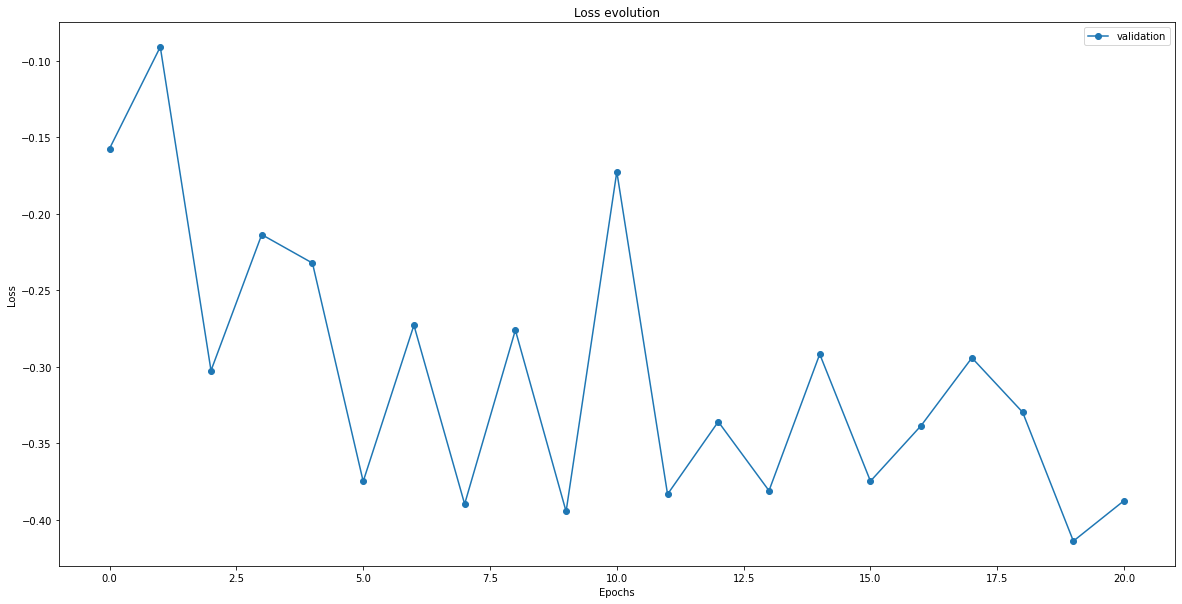

Random seed set as 42


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/457 [00:00<?, ?it/s]

Iter:  0
Train loss:  -1.313
Val loss:  -0.628
Validation Sharpe Ratio
C:  0 SR:  3.043
C:  1 SR:  2.662
C:  5 SR:  1.135
C:  10 SR:  -0.775
Epochs till end:  14



  0%|          | 0/457 [00:00<?, ?it/s]

Iter:  1
Train loss:  -3.273
Val loss:  -0.615
Validation Sharpe Ratio
C:  0 SR:  2.193
C:  1 SR:  1.737
C:  5 SR:  -0.085
C:  10 SR:  -2.357
Epochs till end:  15



  0%|          | 0/457 [00:00<?, ?it/s]

Iter:  2
Train loss:  -4.592
Val loss:  -0.598
Validation Sharpe Ratio
C:  0 SR:  2.224
C:  1 SR:  1.755
C:  5 SR:  -0.121
C:  10 SR:  -2.465
Epochs till end:  15



  0%|          | 0/457 [00:00<?, ?it/s]

Iter:  3
Train loss:  -5.504
Val loss:  -0.45
Validation Sharpe Ratio
C:  0 SR:  1.707
C:  1 SR:  1.137
C:  5 SR:  -1.134
C:  10 SR:  -3.951
Epochs till end:  14



  0%|          | 0/457 [00:00<?, ?it/s]

Iter:  4
Train loss:  -6.213
Val loss:  -0.652
Validation Sharpe Ratio
C:  0 SR:  1.958
C:  1 SR:  1.601
C:  5 SR:  0.177
C:  10 SR:  -1.593
Epochs till end:  13



  0%|          | 0/457 [00:00<?, ?it/s]

Iter:  5
Train loss:  -6.793
Val loss:  -0.315
Validation Sharpe Ratio
C:  0 SR:  0.628
C:  1 SR:  -0.048
C:  5 SR:  -2.733
C:  10 SR:  -6.046
Epochs till end:  12



  0%|          | 0/457 [00:00<?, ?it/s]

Iter:  6
Train loss:  -7.085
Val loss:  -0.407
Validation Sharpe Ratio
C:  0 SR:  2.077
C:  1 SR:  1.506
C:  5 SR:  -0.765
C:  10 SR:  -3.578
Epochs till end:  11



  0%|          | 0/457 [00:00<?, ?it/s]

Iter:  7
Train loss:  -7.568
Val loss:  -0.181
Validation Sharpe Ratio
C:  0 SR:  0.505
C:  1 SR:  -0.148
C:  5 SR:  -2.746
C:  10 SR:  -5.964
Epochs till end:  10



  0%|          | 0/457 [00:00<?, ?it/s]

Iter:  8
Train loss:  -7.895
Val loss:  -0.366
Validation Sharpe Ratio
C:  0 SR:  1.57
C:  1 SR:  1.136
C:  5 SR:  -0.592
C:  10 SR:  -2.74
Epochs till end:  9



  0%|          | 0/457 [00:00<?, ?it/s]

Iter:  9
Train loss:  -8.174
Val loss:  -0.299
Validation Sharpe Ratio
C:  0 SR:  1.238
C:  1 SR:  0.652
C:  5 SR:  -1.687
C:  10 SR:  -4.596
Epochs till end:  8



  0%|          | 0/457 [00:00<?, ?it/s]

Iter:  10
Train loss:  -8.635
Val loss:  -0.311
Validation Sharpe Ratio
C:  0 SR:  1.211
C:  1 SR:  0.685
C:  5 SR:  -1.408
C:  10 SR:  -3.997
Epochs till end:  7



  0%|          | 0/457 [00:00<?, ?it/s]

Iter:  11
Train loss:  -8.824
Val loss:  -0.27
Validation Sharpe Ratio
C:  0 SR:  1.343
C:  1 SR:  0.701
C:  5 SR:  -1.863
C:  10 SR:  -5.054
Epochs till end:  6



  0%|          | 0/457 [00:00<?, ?it/s]

Iter:  12
Train loss:  -9.008
Val loss:  -0.323
Validation Sharpe Ratio
C:  0 SR:  1.713
C:  1 SR:  1.183
C:  5 SR:  -0.927
C:  10 SR:  -3.544
Epochs till end:  5



  0%|          | 0/457 [00:00<?, ?it/s]

Iter:  13
Train loss:  -9.121
Val loss:  -0.198
Validation Sharpe Ratio
C:  0 SR:  0.558
C:  1 SR:  -0.1
C:  5 SR:  -2.718
C:  10 SR:  -5.955
Epochs till end:  4



  0%|          | 0/457 [00:00<?, ?it/s]

Iter:  14
Train loss:  -9.242
Val loss:  -0.164
Validation Sharpe Ratio
C:  0 SR:  0.427
C:  1 SR:  -0.235
C:  5 SR:  -2.869
C:  10 SR:  -6.121
Epochs till end:  3



  0%|          | 0/457 [00:00<?, ?it/s]

Iter:  15
Train loss:  -9.326
Val loss:  -0.278
Validation Sharpe Ratio
C:  0 SR:  1.274
C:  1 SR:  0.581
C:  5 SR:  -2.173
C:  10 SR:  -5.569
Epochs till end:  2



  0%|          | 0/457 [00:00<?, ?it/s]

Iter:  16
Train loss:  -9.495
Val loss:  -0.186
Validation Sharpe Ratio
C:  0 SR:  0.636
C:  1 SR:  -0.014
C:  5 SR:  -2.601
C:  10 SR:  -5.8
Epochs till end:  1



  0%|          | 0/457 [00:00<?, ?it/s]

Iter:  17
Train loss:  -9.588
Val loss:  -0.095
Validation Sharpe Ratio
C:  0 SR:  -0.436
C:  1 SR:  -1.136
C:  5 SR:  -3.925
C:  10 SR:  -7.378
Epochs till end:  0



  0%|          | 0/457 [00:00<?, ?it/s]

Validation dates:  2020-12-31 00:00:00 2021-12-31 00:00:00


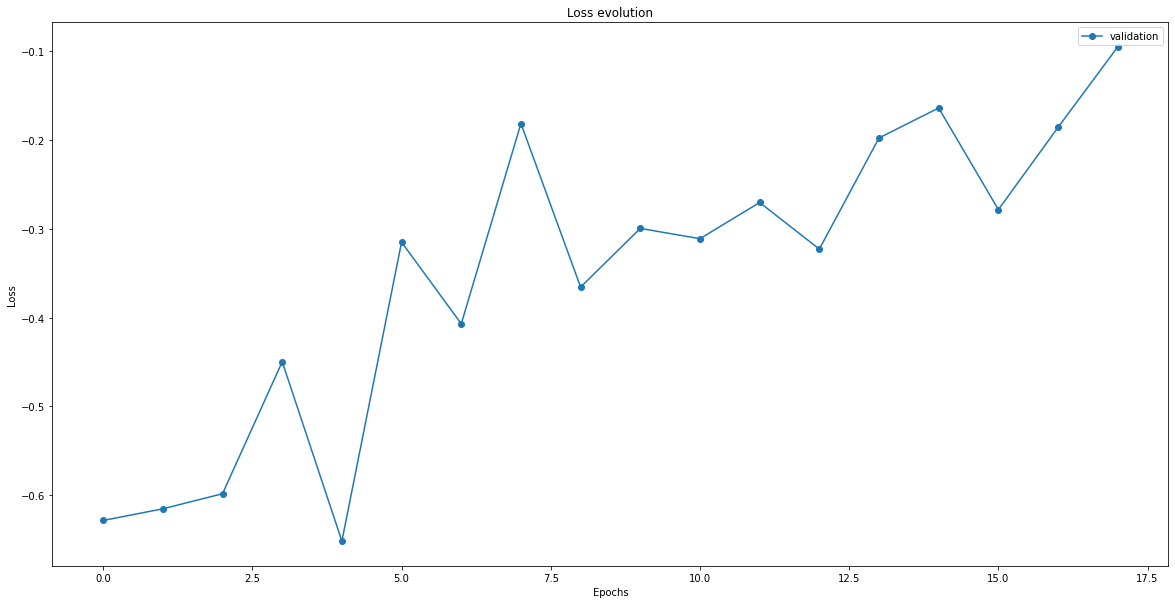

Random seed set as 42


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

Iter:  0
Train loss:  -1.208
Val loss:  -0.272
Validation Sharpe Ratio
C:  0 SR:  0.868
C:  1 SR:  0.679
C:  5 SR:  -0.077
C:  10 SR:  -1.021
Epochs till end:  14



  0%|          | 0/511 [00:00<?, ?it/s]

Iter:  1
Train loss:  -3.099
Val loss:  -0.207
Validation Sharpe Ratio
C:  0 SR:  0.665
C:  1 SR:  0.409
C:  5 SR:  -0.615
C:  10 SR:  -1.891
Epochs till end:  15



  0%|          | 0/511 [00:00<?, ?it/s]

Iter:  2
Train loss:  -4.534
Val loss:  -0.297
Validation Sharpe Ratio
C:  0 SR:  1.305
C:  1 SR:  0.957
C:  5 SR:  -0.432
C:  10 SR:  -2.163
Epochs till end:  15



  0%|          | 0/511 [00:00<?, ?it/s]

Iter:  3
Train loss:  -5.485
Val loss:  -0.093
Validation Sharpe Ratio
C:  0 SR:  -0.239
C:  1 SR:  -0.551
C:  5 SR:  -1.797
C:  10 SR:  -3.352
Epochs till end:  14



  0%|          | 0/511 [00:00<?, ?it/s]

Iter:  4
Train loss:  -6.188
Val loss:  -0.058
Validation Sharpe Ratio
C:  0 SR:  -0.089
C:  1 SR:  -0.482
C:  5 SR:  -2.051
C:  10 SR:  -4.007
Epochs till end:  13



  0%|          | 0/511 [00:00<?, ?it/s]

Iter:  5
Train loss:  -6.713
Val loss:  -0.067
Validation Sharpe Ratio
C:  0 SR:  -0.291
C:  1 SR:  -0.685
C:  5 SR:  -2.255
C:  10 SR:  -4.213
Epochs till end:  12



  0%|          | 0/511 [00:00<?, ?it/s]

Iter:  6
Train loss:  -7.132
Val loss:  -0.043
Validation Sharpe Ratio
C:  0 SR:  -0.219
C:  1 SR:  -0.591
C:  5 SR:  -2.074
C:  10 SR:  -3.923
Epochs till end:  11



  0%|          | 0/511 [00:00<?, ?it/s]

Iter:  7
Train loss:  -7.453
Val loss:  -0.177
Validation Sharpe Ratio
C:  0 SR:  0.785
C:  1 SR:  0.383
C:  5 SR:  -1.225
C:  10 SR:  -3.235
Epochs till end:  10



  0%|          | 0/511 [00:00<?, ?it/s]

Iter:  8
Train loss:  -7.737
Val loss:  -0.174
Validation Sharpe Ratio
C:  0 SR:  0.871
C:  1 SR:  0.548
C:  5 SR:  -0.745
C:  10 SR:  -2.363
Epochs till end:  9



  0%|          | 0/511 [00:00<?, ?it/s]

Iter:  9
Train loss:  -7.977
Val loss:  -0.115
Validation Sharpe Ratio
C:  0 SR:  0.416
C:  1 SR:  0.033
C:  5 SR:  -1.496
C:  10 SR:  -3.405
Epochs till end:  8



  0%|          | 0/511 [00:00<?, ?it/s]

Iter:  10
Train loss:  -8.435
Val loss:  -0.209
Validation Sharpe Ratio
C:  0 SR:  0.782
C:  1 SR:  0.474
C:  5 SR:  -0.755
C:  10 SR:  -2.291
Epochs till end:  7



  0%|          | 0/511 [00:00<?, ?it/s]

Iter:  11
Train loss:  -8.616
Val loss:  -0.149
Validation Sharpe Ratio
C:  0 SR:  0.772
C:  1 SR:  0.358
C:  5 SR:  -1.296
C:  10 SR:  -3.356
Epochs till end:  6



  0%|          | 0/511 [00:00<?, ?it/s]

Iter:  12
Train loss:  -8.753
Val loss:  -0.113
Validation Sharpe Ratio
C:  0 SR:  0.543
C:  1 SR:  0.189
C:  5 SR:  -1.228
C:  10 SR:  -2.994
Epochs till end:  5



  0%|          | 0/511 [00:00<?, ?it/s]

Iter:  13
Train loss:  -8.917
Val loss:  -0.166
Validation Sharpe Ratio
C:  0 SR:  1.083
C:  1 SR:  0.675
C:  5 SR:  -0.958
C:  10 SR:  -3.0
Epochs till end:  4



  0%|          | 0/511 [00:00<?, ?it/s]

Iter:  14
Train loss:  -9.022
Val loss:  -0.074
Validation Sharpe Ratio
C:  0 SR:  0.69
C:  1 SR:  0.289
C:  5 SR:  -1.314
C:  10 SR:  -3.316
Epochs till end:  3



  0%|          | 0/511 [00:00<?, ?it/s]

Iter:  15
Train loss:  -9.116
Val loss:  -0.147
Validation Sharpe Ratio
C:  0 SR:  0.987
C:  1 SR:  0.58
C:  5 SR:  -1.047
C:  10 SR:  -3.071
Epochs till end:  2



  0%|          | 0/511 [00:00<?, ?it/s]

Iter:  16
Train loss:  -9.207
Val loss:  -0.119
Validation Sharpe Ratio
C:  0 SR:  0.45
C:  1 SR:  0.034
C:  5 SR:  -1.626
C:  10 SR:  -3.698
Epochs till end:  1



  0%|          | 0/511 [00:00<?, ?it/s]

Iter:  17
Train loss:  -9.32
Val loss:  -0.151
Validation Sharpe Ratio
C:  0 SR:  0.422
C:  1 SR:  0.14
C:  5 SR:  -0.987
C:  10 SR:  -2.393
Epochs till end:  0



  0%|          | 0/511 [00:00<?, ?it/s]

Validation dates:  2021-12-31 00:00:00 2022-12-31 00:00:00


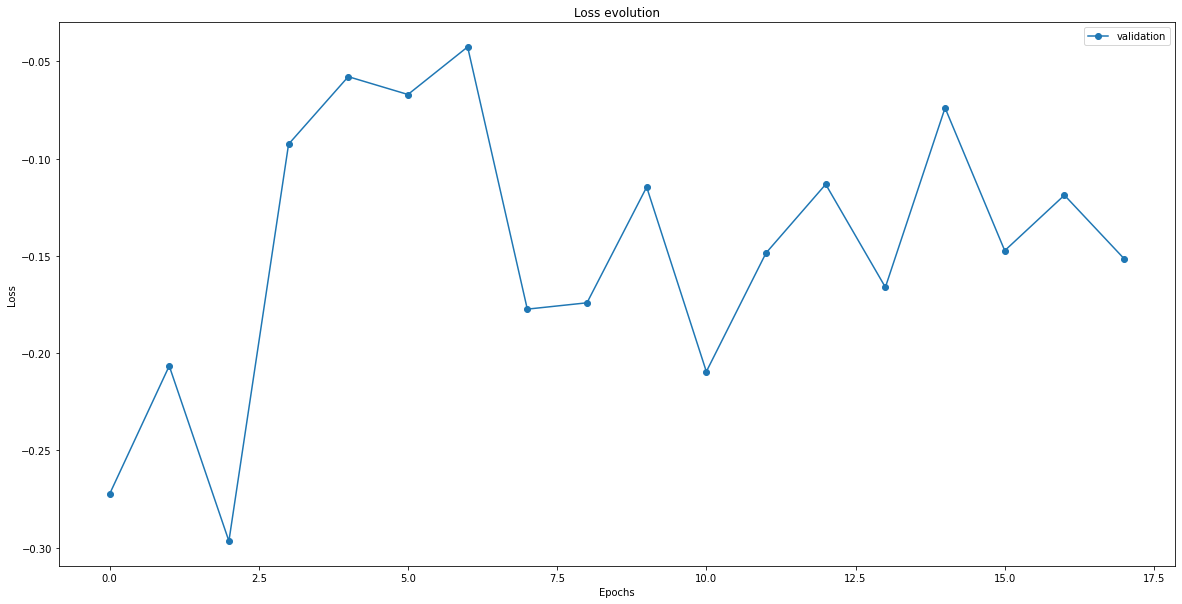

In [20]:
for seed in [42]:
    
    if not os.path.exists('weights'):
        os.mkdir('weights')
    if not os.path.exists('results'):
        os.mkidr('results')
    
    test_dts = []
    results = {}
    splitter = UnivariateTrainValTestSplitter(features, cols_to_use, datetime_cols, 'target_returns', 'target_returns_nonscaled',
                                        'daily_vol', scaling=scaling, timesteps=history_size)
    for start in date_range:
        train_loader, val_loader, test_loader, test_dt = splitter.split(start, val_delta, test_delta, seed)
        test_dts.append(test_dt)
        if len(test_loader) == 0:
            continue
        
        dt = start
        results[dt] = {}
        
        batch_x, batch_y, batch_mask, batch_vol = next(iter(train_loader))
        
        input_dim = batch_x.shape[2]
        output_dim = 1
        timesteps = history_size
        
        _set_seed(seed)
        model = MODEL_MAPPING[model_type](input_dim, output_dim, timesteps, **model_params).to(device)
        
        opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        sc = torch.optim.lr_scheduler.StepLR(opt, decay_steps, decay_gamma)

        counter = 0
        
        train_losses = []
        train_l1_losses = []
        train_turnover_losses = []
        val_losses = []
        val_turnover_losses = []
        best_val_sharpe = np.NINF
        
        for e in tqdm(range(n_epochs)):
            train_loss = 0
            train_l1_loss = 0
            train_turnover_loss = 0
            model.train()
            for batch_x, batch_y, batch_mask, batch_vol in tqdm(train_loader):
                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)
                batch_mask = batch_mask.to(device)
                batch_vol = batch_vol.to(device)

                opt.zero_grad()

                output = model(batch_x)

                l = sharpe_loss(output, batch_y, batch_mask)
                train_loss += l.item()

                if apply_turnover_reg:
                    l_turnover = reg_turnover(output, batch_vol, batch_mask)
                    train_turnover_loss += l_turnover.item()
                    l += l_turnover
                
                l.backward()
                opt.step()
            
            # we do not want learning rate to be too small
            if sc.get_last_lr()[0] > 1e-5:
                sc.step()
            
            val_loss = 0
            val_turnover_loss = 0
            
            preds, returns, vols = [], [], []
            
            model.eval()
            
            with torch.no_grad():
                for batch_x, batch_y, batch_vol in val_loader:
                    preds_, returns_, vols_ = [], [], []
                
                    for key in batch_x.keys():
                        batch_x[key] = batch_x[key].to(device)
                        batch_y[key] = batch_y[key].to(device)
                        batch_vol[key] = batch_vol[key].to(device)

                        output = model(batch_x[key])
                        
                        l = sharpe_loss(output, batch_y[key])
                        val_loss += l.item()

                        if apply_turnover_reg:
                            l_turnover = reg_turnover(output, batch_vol[key])
                            val_turnover_loss += l_turnover.item()

                        # select last timestep as we no longer need for time axis in batch
                        returns_.append(batch_y[key][:, -1, :].detach().cpu().numpy())
                        preds_.append(output[:, -1, :].detach().cpu().numpy())
                        vols_.append(batch_vol[key][:, -1, :].detach().cpu().numpy())
                    
                    val_loss /= len(batch_x.keys())
                    
                    preds_ = np.concatenate(preds_, axis=-1)
                    returns_ = np.concatenate(returns_, axis=-1)
                    vols_ = np.concatenate(vols_, axis=-1)
                    
                    preds.append(preds_)
                    returns.append(returns_)
                    vols.append(vols_)
                    
            preds = np.concatenate(preds)
            returns = np.concatenate(returns)
            vols = np.concatenate(vols)
            
            #annualized volatility
            vols = vols * 252**0.5
            # validation turnover
            T = target_vol*np.abs(np.diff(preds/(vols+1e-12), prepend=0.0, axis=0))
            # validation sharpe ratios with different turnover strength
            val_sharpes = {}

            for c in basis_points:
                captured = returns*preds - 1e-4*c*T
                R = np.mean(captured, axis=1)
                sharpes = sharpe_ratio(R)
                #sharpes = [sharpe_ratio(captured[:, i]) for i in range(captured.shape[1])]
                sharpes = np.mean(sharpes)
                val_sharpes[c] = sharpes
                
            # one can use sharpe ratio averaged by all turnover coefficients as validation performance metric
            #val_sharpe = np.mean(list(val_sharpes.values()))
            
            val_sharpe = val_sharpes[0]
            
            if best_val_sharpe < val_sharpe and e > 0:
                best_val_sharpe = val_sharpe
                counter = 0
                torch.save(model.state_dict(), os.path.join('weights', '{}_seed_{}_uni.pt'.format(model_type, seed)))
            
            else:
                counter += 1
            
            if counter > early_stopping_rounds:
                break
            
            train_loss /= len(train_loader)
            train_l1_loss/= len(train_loader)
            train_turnover_loss /= len(train_loader)
            val_loss /= len(val_loader)
            val_turnover_loss /= len(val_loader)
            
            train_losses.append(train_loss)
            train_l1_losses.append(train_l1_loss)
            train_turnover_losses.append(train_turnover_loss)
            val_losses.append(val_loss)
            val_turnover_losses.append(val_turnover_loss)
            
            print('Iter: ', e)
            print('Train loss: ', round(train_losses[-1], 3))
            print('Val loss: ', round(val_losses[-1], 3))
            print('Validation Sharpe Ratio')
            for key in val_sharpes.keys():
                print('C: ', key, 'SR: ', round(val_sharpes[key], 3))
            if apply_l1_reg:
                print('L1 loss', round(train_l1_losses[-1], 5))
            if apply_turnover_reg:
                print('Train turnover loss: ', round(train_turnover_losses[-1], 5))
                print('Val turnover loss: ', round(val_turnover_losses[-1], 5))
            print('Epochs till end: ', early_stopping_rounds - counter)
            print()
        
        print('Validation dates: ', start, start+val_delta)
        
        plt.figure(figsize=(20, 10))
        plt.title('Loss evolution')
        #plt.plot(train_losses, label='train', marker='o')
        plt.plot(val_losses, label='validation', marker='o')
        plt.ylabel('Loss')
        plt.xlabel('Epochs')
        plt.legend()
        plt.show()
        
        if apply_l1_reg:
            plt.figure(figsize=(20, 10))
            plt.title('L1 regularization loss evolution')
            plt.plot(train_l1_losses, label='train', marker='o')
            plt.ylabel('L1 Loss')
            plt.xlabel('Epochs')
            plt.legend()
            plt.show()
        
        if apply_turnover_reg:
            plt.figure(figsize=(20, 10))
            plt.title('Turnover loss evolution')
            plt.plot(train_turnover_losses, label='train', marker='o')
            plt.plot(val_turnover_losses, label='validation', marker='o')
            plt.ylabel('Turnover loss')
            plt.xlabel('Epochs')
            plt.legend()
            plt.show()
        
        model.load_state_dict(torch.load(os.path.join('weights', '{}_seed_{}_uni.pt'.format(model_type, seed))))
        model = model.to(device)
        model.eval()
        
        val_preds = []
        val_returns = []
        #val_returns_orig = []
        val_vols = []

        model.eval()

        with torch.no_grad():
            for batch_x, batch_y, batch_vol in val_loader:
                preds_, returns_, vols_ = [], [], []

                for key in batch_x.keys():
                    batch_x[key] = batch_x[key].to(device)
                    batch_y[key] = batch_y[key].to(device)
                    batch_vol[key] = batch_vol[key].to(device)

                    output = model(batch_x[key])

                
                    returns_.append(batch_y[key][:, -1, :].detach().cpu().numpy())
                    preds_.append(output[:, -1, :].detach().cpu().numpy())
                    vols_.append(batch_vol[key][:, -1, :].detach().cpu().numpy())


                preds_ = np.concatenate(preds_, axis=-1)
                returns_ = np.concatenate(returns_, axis=-1)
                vols_ = np.concatenate(vols_, axis=-1)

                val_preds.append(preds_)
                val_returns.append(returns_)
                val_vols.append(vols_)


        val_preds = np.concatenate(val_preds)
        val_returns = np.concatenate(val_returns)
        #val_returns_orig = np.concatenate(val_returns_orig)
        val_vols = np.concatenate(val_vols)
        
        test_preds = []
        test_returns = []
        #test_returns_orig = []
        test_vols = []

        with torch.no_grad():
            for batch_x, batch_y, batch_vol in test_loader:
                preds_, returns_, vols_ = [], [], []

                for key in batch_x.keys():
                    batch_x[key] = batch_x[key].to(device)
                    batch_y[key] = batch_y[key].to(device)
                    batch_vol[key] = batch_vol[key].to(device)

                    output = model(batch_x[key])

                
                    returns_.append(batch_y[key][:, -1, :].detach().cpu().numpy())
                    preds_.append(output[:, -1, :].detach().cpu().numpy())
                    vols_.append(batch_vol[key][:, -1, :].detach().cpu().numpy())

                

                preds_ = np.concatenate(preds_, axis=-1)
                returns_ = np.concatenate(returns_, axis=-1)
                vols_ = np.concatenate(vols_, axis=-1)

                test_preds.append(preds_)
                test_returns.append(returns_)
                test_vols.append(vols_)


        test_preds = np.concatenate(test_preds)
        test_returns = np.concatenate(test_returns)
        #test_returns_orig = np.concatenate(test_returns_orig)
        test_vols = np.concatenate(test_vols)

        results[dt]['val'] = {}
        results[dt]['test'] = {}
        results[dt]['test_dt'] = test_dt
        
        results[dt]['val']['preds'] = val_preds
        results[dt]['val']['returns'] = val_returns
        #results[dt]['val']['returns_orig'] = val_returns_orig
        results[dt]['val']['vols'] = val_vols
        
        results[dt]['test']['preds'] = test_preds
        results[dt]['test']['returns'] = test_returns
        #results[dt]['test']['returns_orig'] = test_returns_orig
        results[dt]['test']['vols'] = test_vols
        
        
        
    with open(os.path.join('results', '{}_seed_{}_univariate.pickle'.format(model_type, seed)), 'wb') as f:
        pickle.dump(results, f)

In [22]:
with open(os.path.join('results', '{}_seed_{}_univariate.pickle'.format(model_type, seed)), 'wb') as f:
    pickle.dump(results, f)

In [21]:
test_loader

In [24]:
dt

Timestamp('2018-01-01 00:00:00', freq='365D')

In [40]:
returns_.shape

(230, 55)

In [87]:
output.shape

torch.Size([256, 21, 1])

In [18]:
val_loss = 0
val_turnover_loss = 0

preds = []
returns = []
vols = []


preds1 = []
returns1 = []
vols1 = []

model.eval()

with torch.no_grad():
    for batch_x, batch_y, _, batch_vol in val_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        batch_vol = batch_vol.to(device)

        output = model(batch_x)

        l = sharpe_loss(output, batch_y)
        val_loss += l.item()
        print(l)

        if apply_turnover_reg:
            l_turnover = reg_turnover(output, batch_vol)
            val_turnover_loss += l_turnover.item()

        # select last timestep as we no longer need for time axis in batch
        returns.append(batch_y[:, -1, :].detach().cpu().numpy())
        preds.append(output[:, -1, :].detach().cpu().numpy())
        vols.append(batch_vol[:, -1, :].detach().cpu().numpy())
        
        returns1.append(batch_y.detach().cpu().numpy())
        preds1.append(output.detach().cpu().numpy())
        vols1.append(batch_vol.detach().cpu().numpy())

# preds = np.concatenate(preds)
# returns = np.concatenate(returns)
# vols = np.concatenate(vols)

tensor(-1.3805)
tensor(-1.5015)
tensor(-1.1801)
tensor(-1.4442)


In [207]:
val_loss /= 4

In [208]:
val_loss

-0.583526136353612

In [19]:
preds = np.concatenate(preds)
returns = np.concatenate(returns)
vols = np.concatenate(vols)

In [20]:
preds1 = np.concatenate(preds1)
returns1 = np.concatenate(returns1)
vols1 = np.concatenate(vols1)

In [23]:
sharpe_loss(torch.Tensor(preds1), torch.Tensor(returns1))

tensor(-1.3384)

In [26]:
preds1[0, :, 0]

array([-1.        , -1.        ,  1.        ,  1.        ,  1.        ,
        1.        , -1.        , -0.99967563,  1.        ,  0.28726384,
       -1.        ,  1.        , -0.9985687 ,  0.99979705, -1.        ,
       -1.        ,  1.        , -1.        ,  1.        ,  1.        ,
        0.9740826 ], dtype=float32)

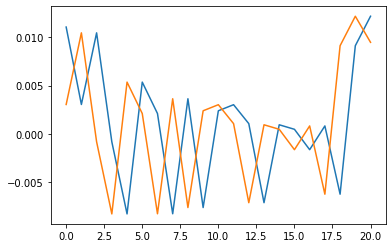

In [28]:
plt.plot(returns1[0, :, 0])
plt.plot(returns1[1, :, 0])

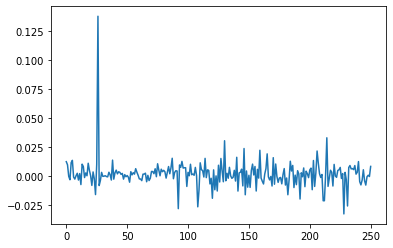

In [29]:
plt.plot(returns1[:, -1, 0])

In [21]:
sharpe_loss(torch.Tensor(preds).unsqueeze(0), torch.Tensor(returns).unsqueeze(0))

tensor(-0.3043)

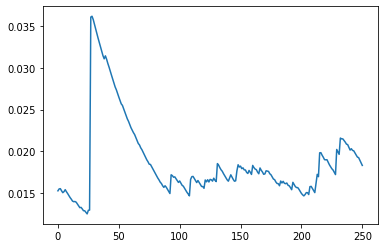

In [211]:
plt.plot(vols[:, 0])

In [212]:
Cs = [0.5]

In [213]:
vols

array([[0.015244  , 0.01095149, 0.01201427, ..., 0.01180266, 0.01006786,
        0.01366457],
       [0.01547271, 0.01077143, 0.01184592, ..., 0.01160879, 0.00999579,
        0.01352119],
       [0.01550223, 0.01064841, 0.01235926, ..., 0.01145054, 0.00983458,
        0.01330805],
       ...,
       [0.01891026, 0.00948685, 0.01533236, ..., 0.00751706, 0.00839446,
        0.01270238],
       [0.01859819, 0.0093732 , 0.01510374, ..., 0.00747508, 0.00838829,
        0.01263919],
       [0.01829264, 0.00923667, 0.01498667, ..., 0.00735268, 0.0082502 ,
        0.01243048]], dtype=float32)

In [214]:
vols = vols * 252**0.5

In [215]:
vols

array([[0.24199107, 0.17384957, 0.19072066, ..., 0.1873615 , 0.15982236,
        0.21691829],
       [0.24562168, 0.1709911 , 0.18804812, ..., 0.18428385, 0.15867822,
        0.21464229],
       [0.2460903 , 0.16903834, 0.19619724, ..., 0.18177176, 0.1561192 ,
        0.21125868],
       ...,
       [0.30019104, 0.15059912, 0.2433937 , ..., 0.11932955, 0.13325797,
        0.20164399],
       [0.29523712, 0.1487949 , 0.23976447, ..., 0.11866328, 0.13315994,
        0.20064092],
       [0.29038668, 0.14662753, 0.23790602, ..., 0.11672015, 0.13096787,
        0.19732782]], dtype=float32)

In [216]:
Cs = list(range(0, 12, 2))

In [217]:
Cs

[0, 2, 4, 6, 8, 10]

In [219]:
T = target_vol*np.abs(np.diff(preds/(vols+1e-12), prepend=0.0, axis=0))
# validation sharpe ratios with different turnover strength
val_sharpes = {}

for c in Cs:
    captured = returns*preds - c*T*1e-4
    R = np.mean(captured, axis=1)
    sharpes = sharpe_ratio(R)
    #sharpes = [sharpe_ratio(captured[:, i]) for i in range(captured.shape[1])]
    #sharpes = np.mean(sharpes)
    val_sharpes[c] = sharpes

In [222]:
np.mean(list(val_sharpes.values()))

0.26255494627629644

In [201]:
lb = [0, 0.5]

In [202]:
np.atleast_2d(lb)

array([[0. , 0.5]])

In [200]:
sharpes

-31.848086721889615

In [141]:
target_vol

0.15

In [122]:
dd = np.abs(np.diff(preds))

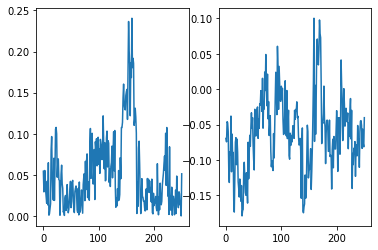

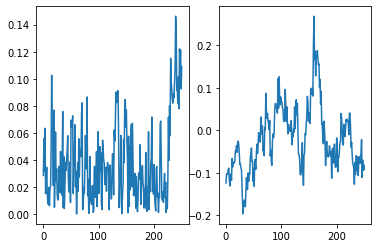

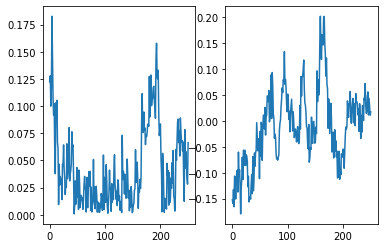

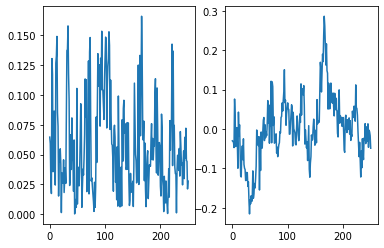

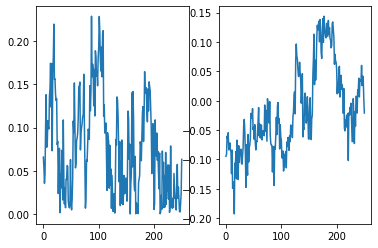

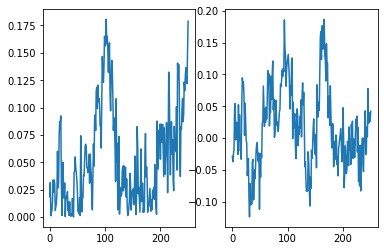

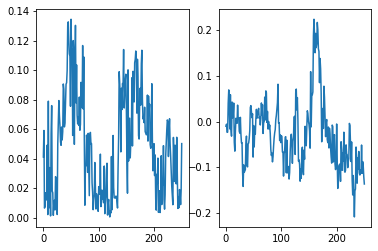

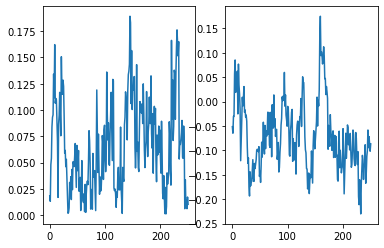

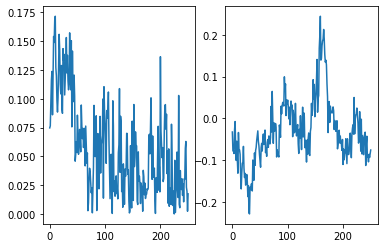

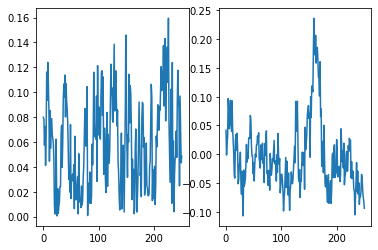

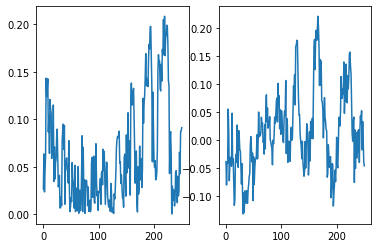

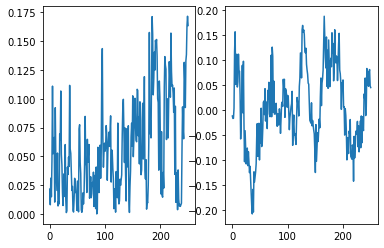

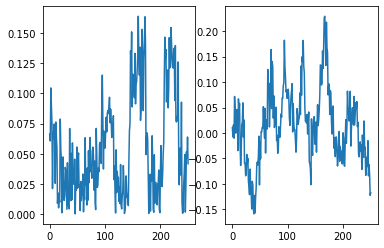

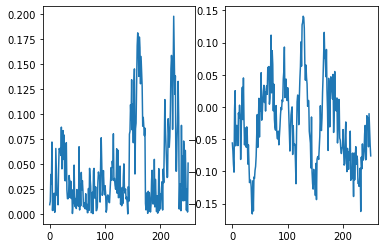

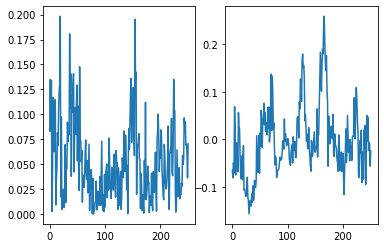

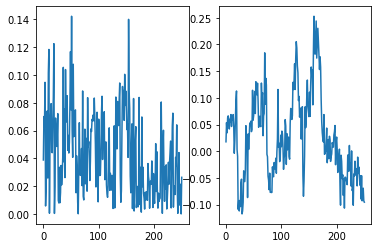

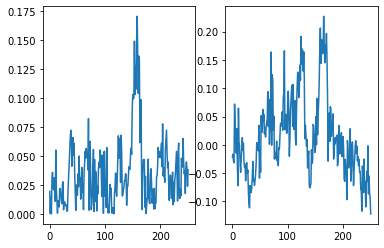

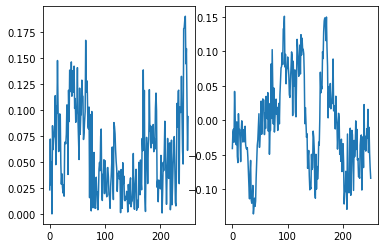

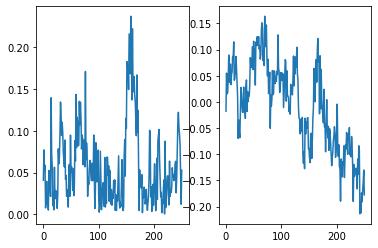

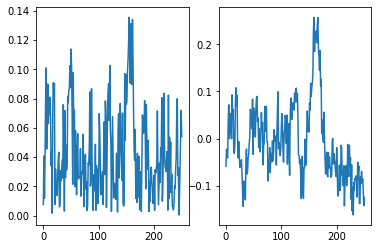

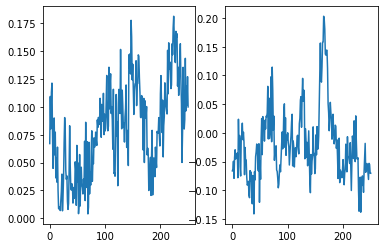

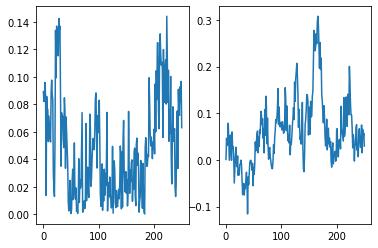

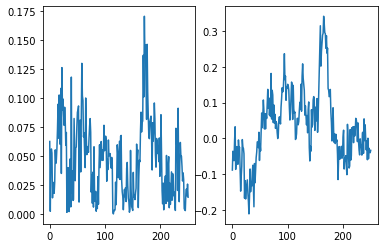

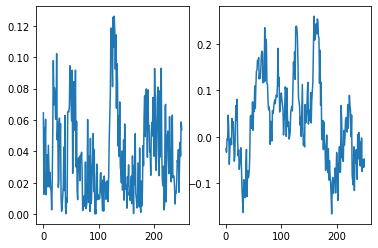

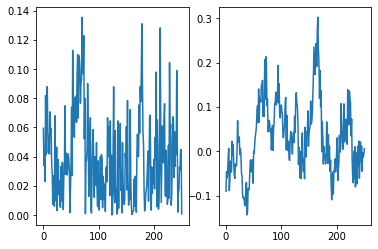

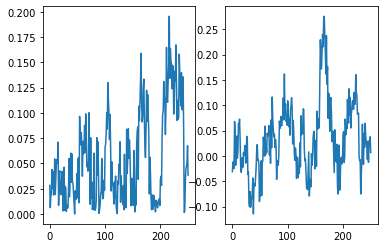

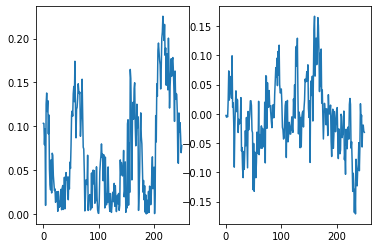

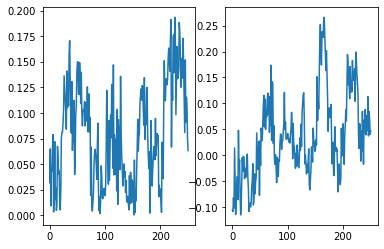

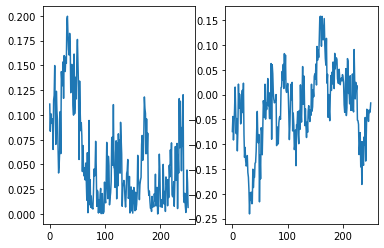

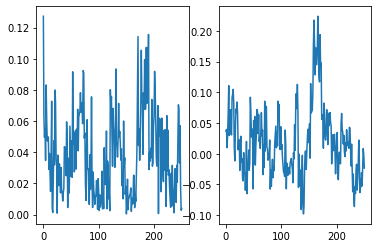

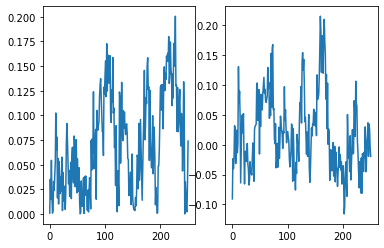

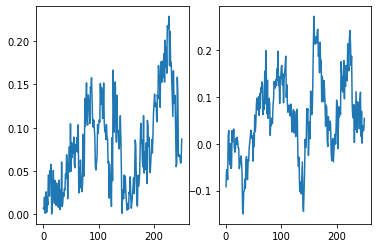

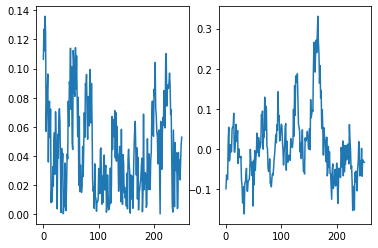

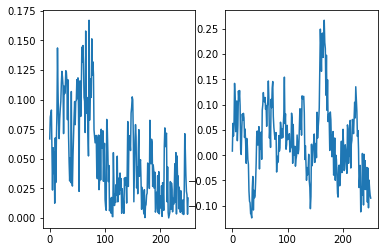

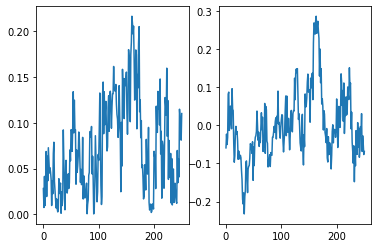

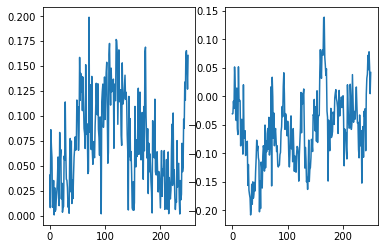

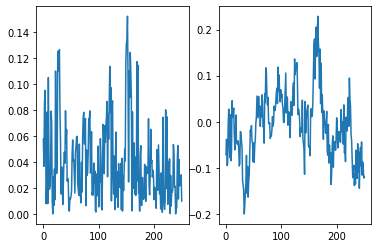

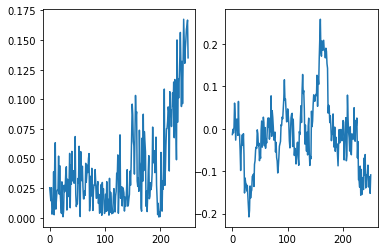

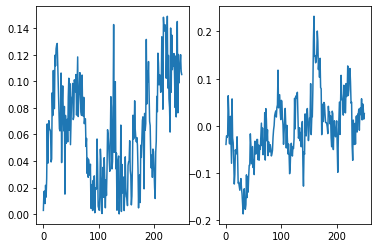

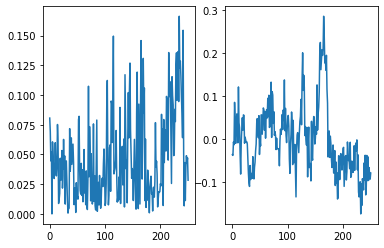

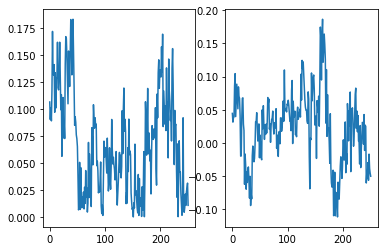

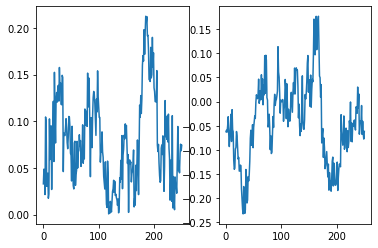

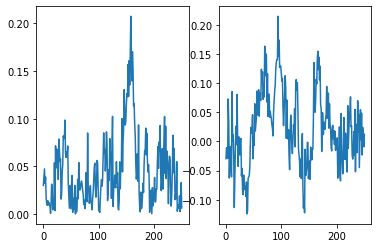

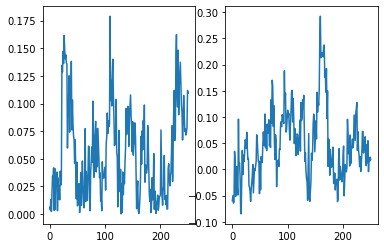

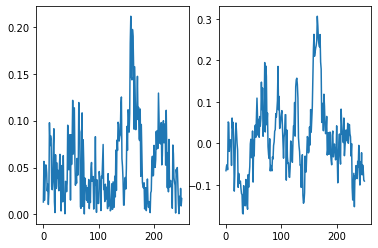

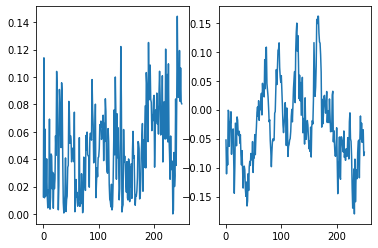

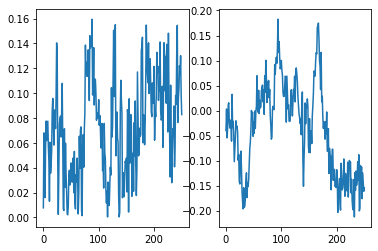

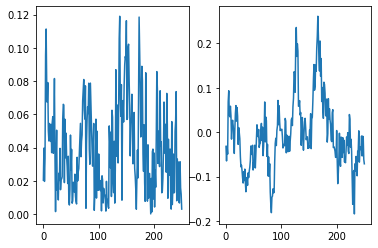

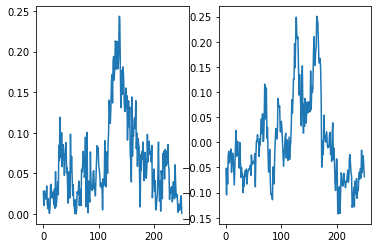

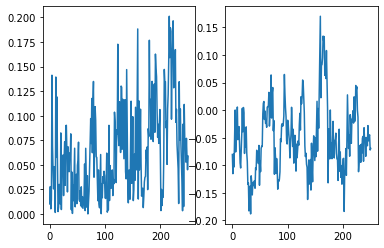

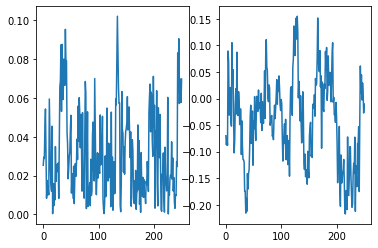

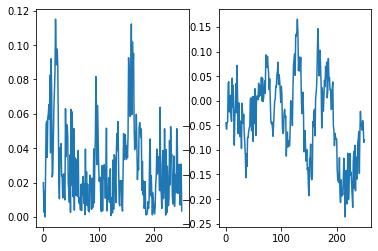

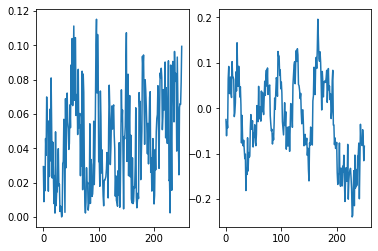

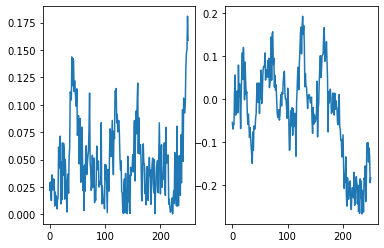

IndexError: index 54 is out of bounds for axis 1 with size 54

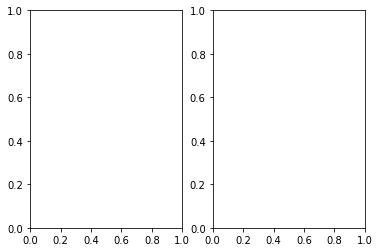

In [124]:
for i in range(55):
    fig, ax = plt.subplots(1, 2)
    ax[0].plot(dd[:, i])
    ax[1].plot(preds[:, i])
    plt.show()

In [103]:
c2 = captured.copy()

In [99]:
#c1 = captured.copy()

In [105]:
T.shape

(251, 55)

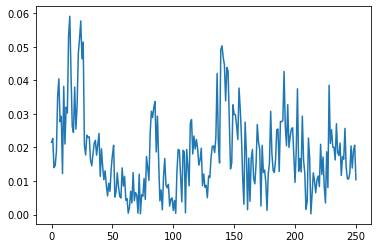

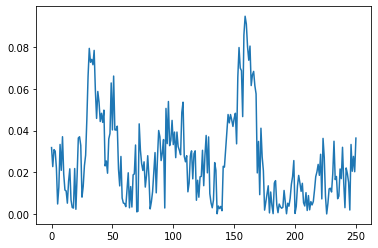

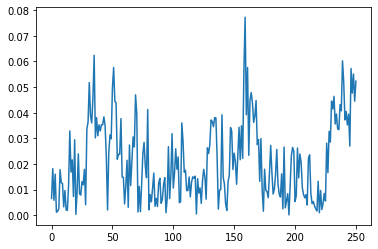

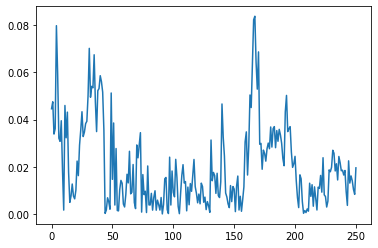

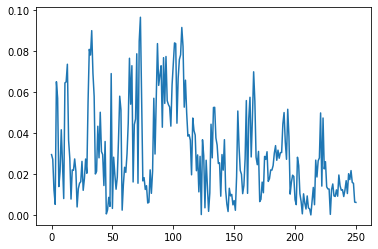

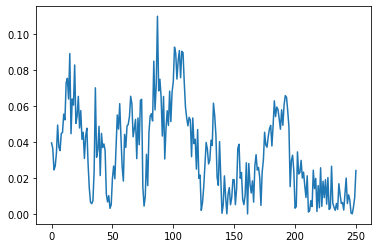

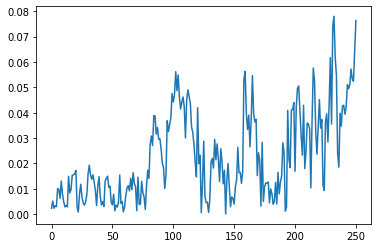

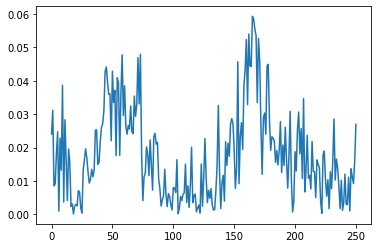

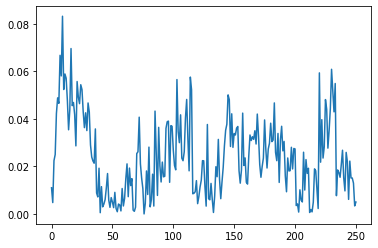

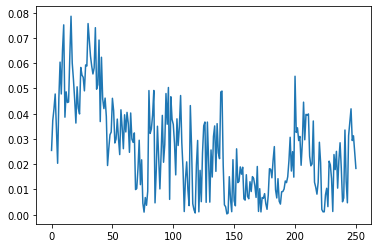

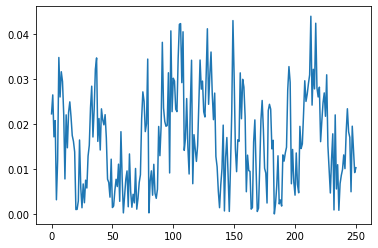

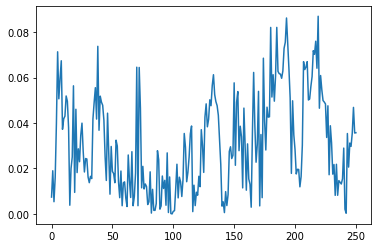

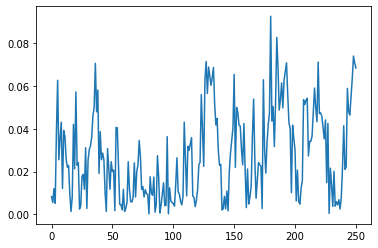

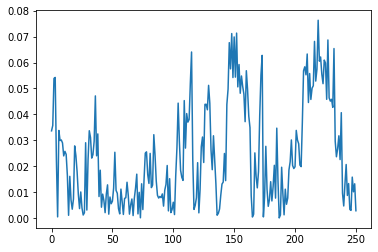

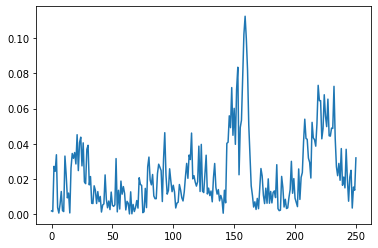

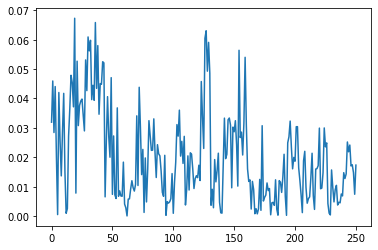

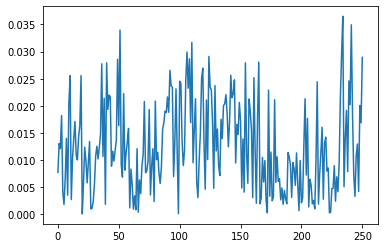

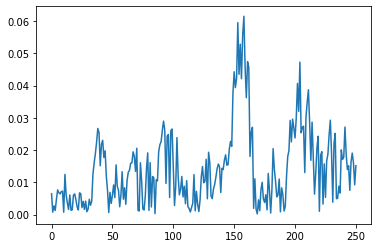

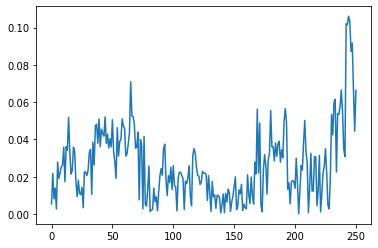

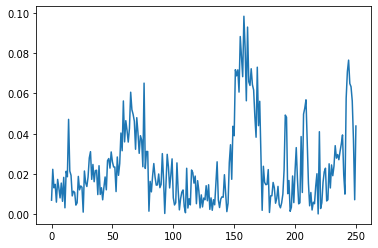

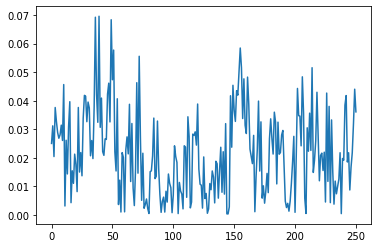

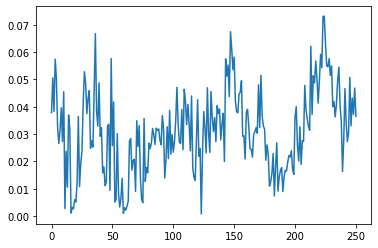

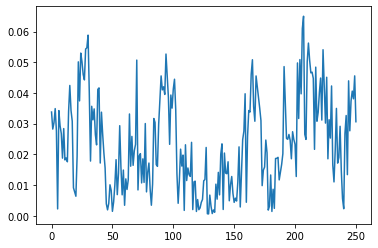

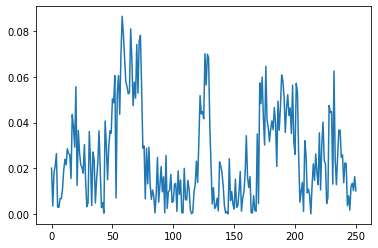

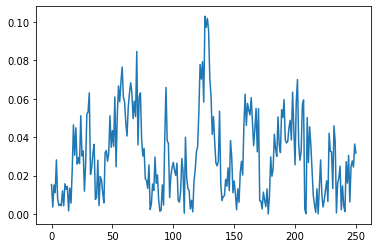

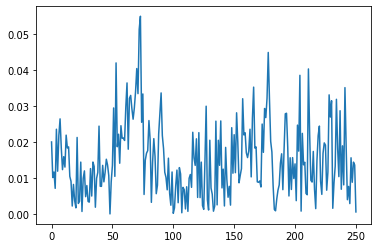

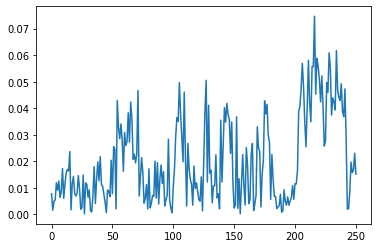

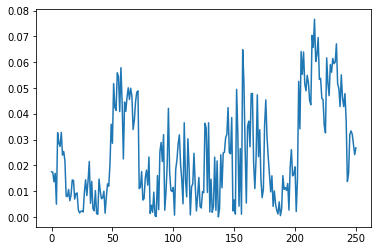

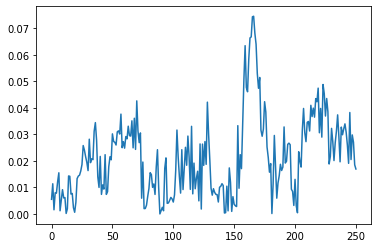

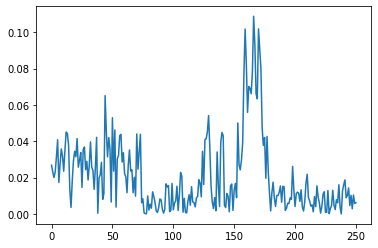

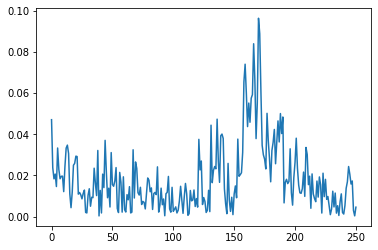

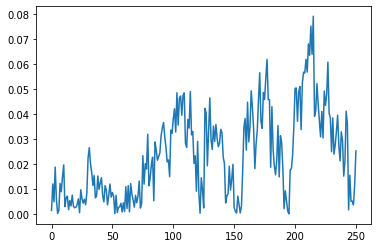

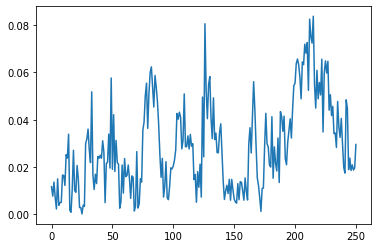

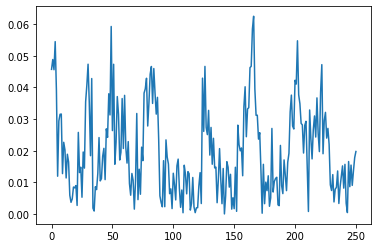

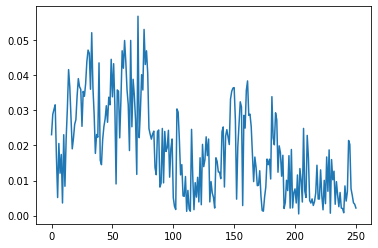

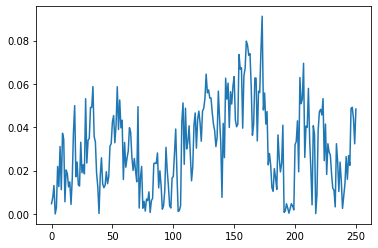

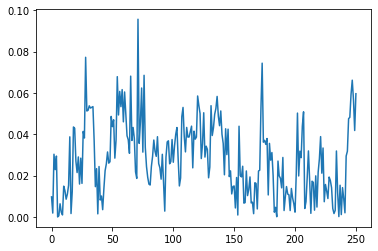

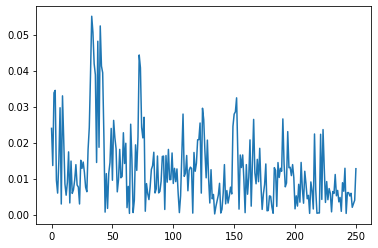

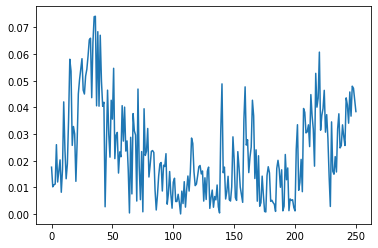

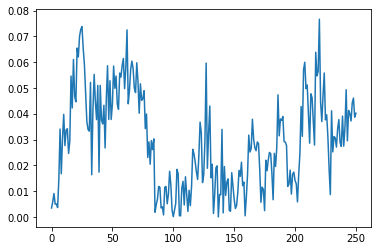

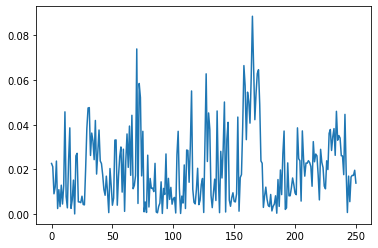

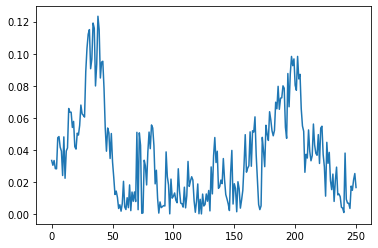

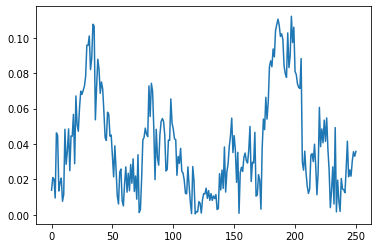

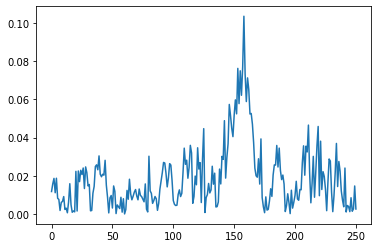

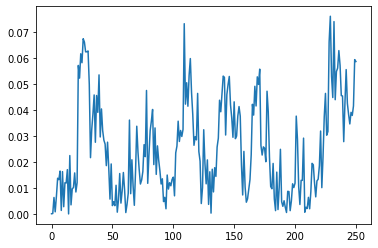

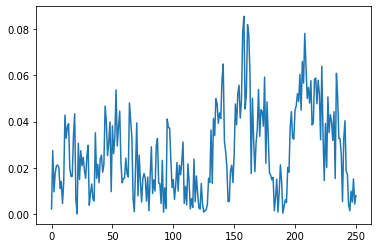

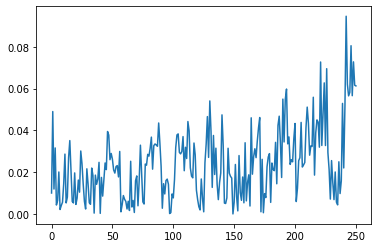

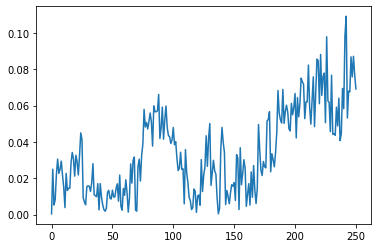

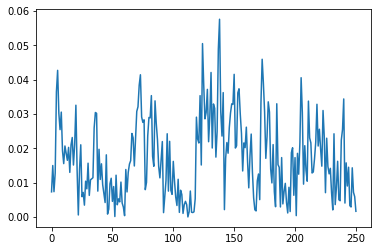

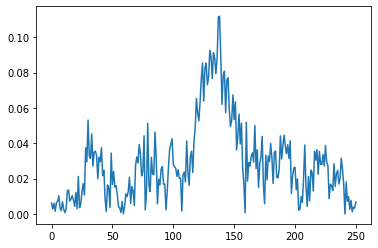

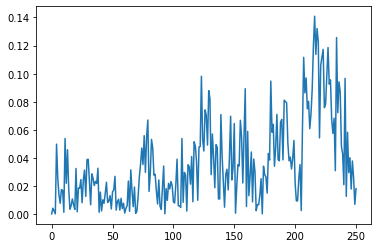

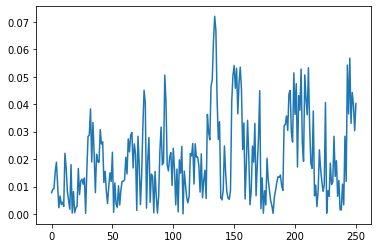

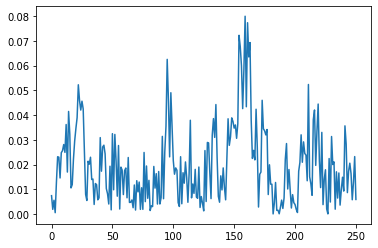

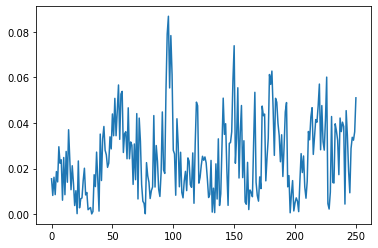

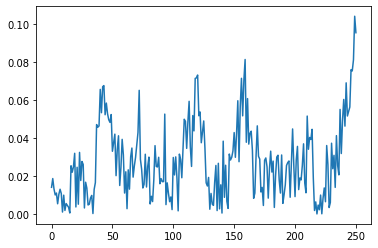

In [140]:
for i in range(55):
    plt.plot(T[:, i]*0.5)
    plt.show()

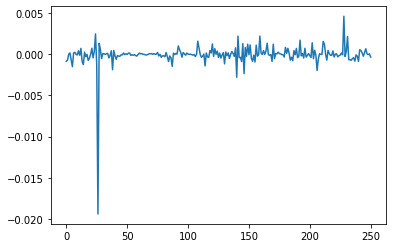

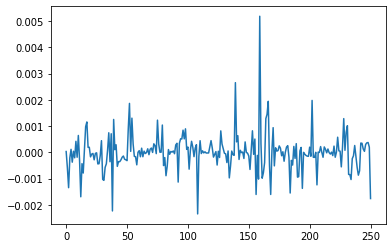

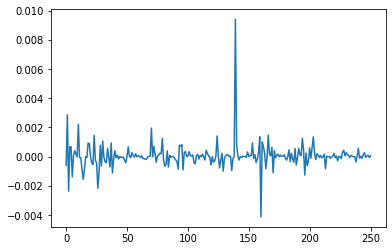

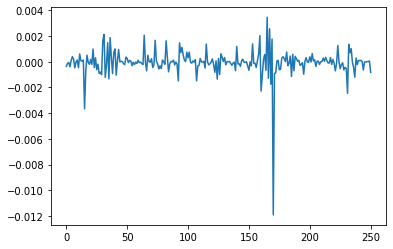

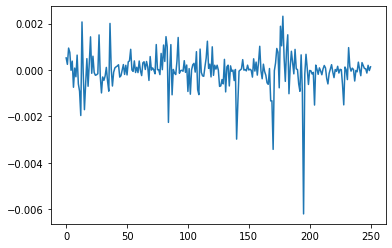

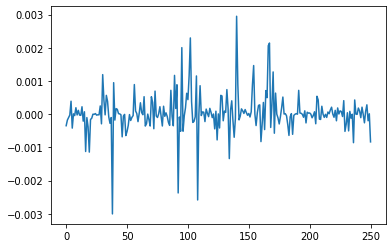

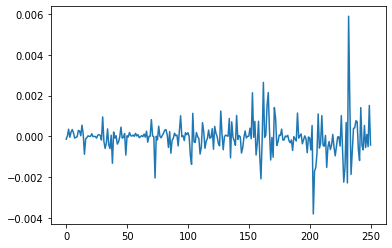

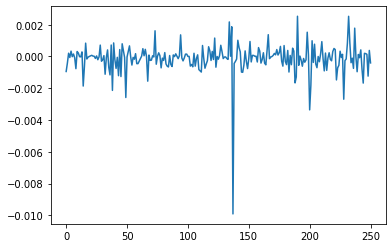

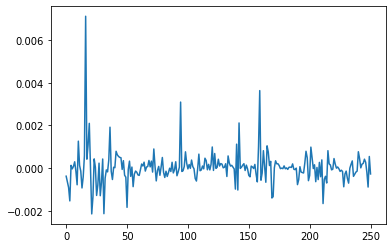

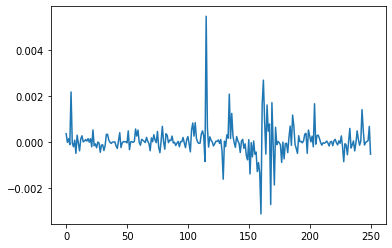

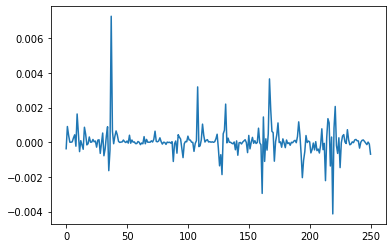

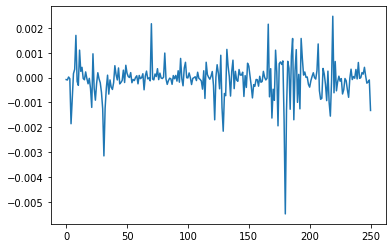

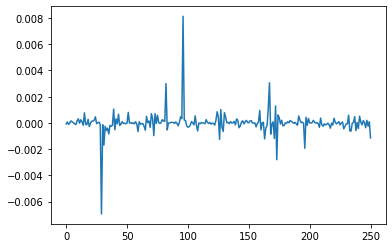

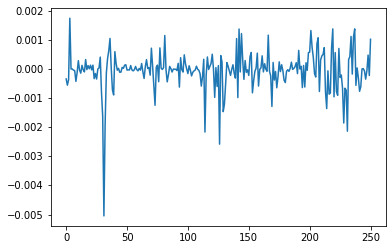

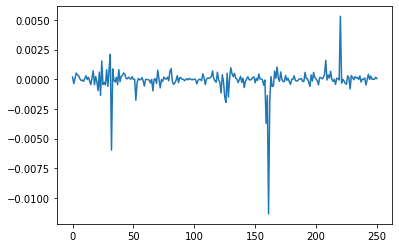

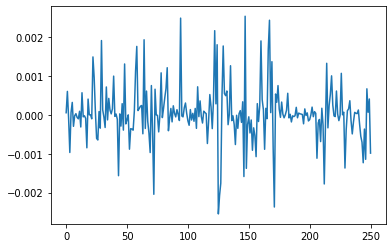

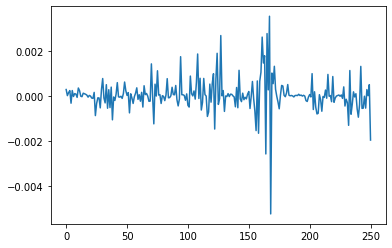

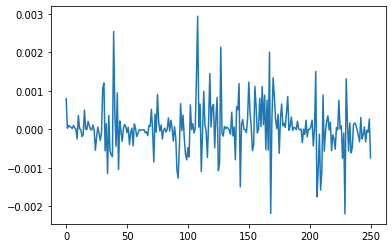

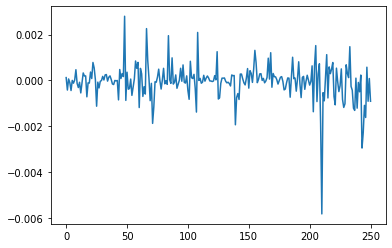

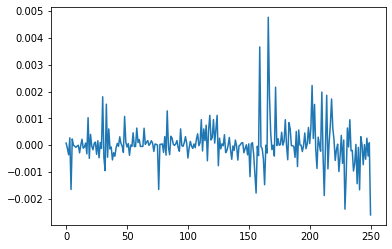

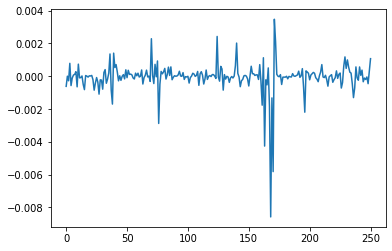

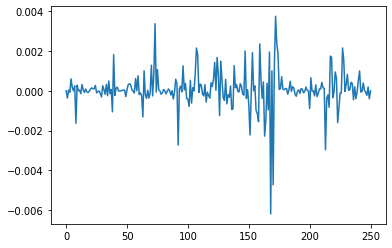

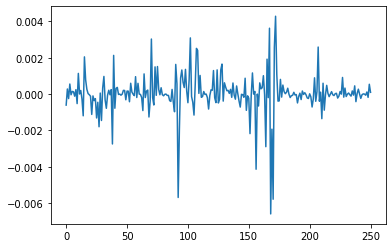

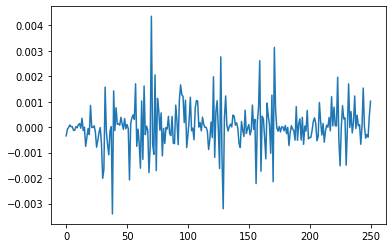

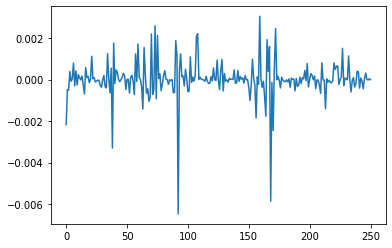

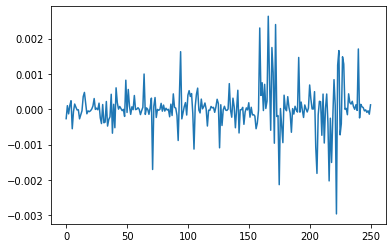

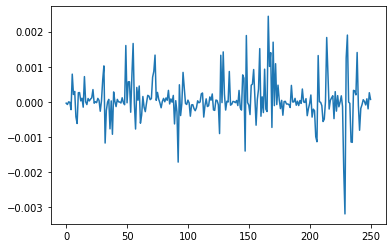

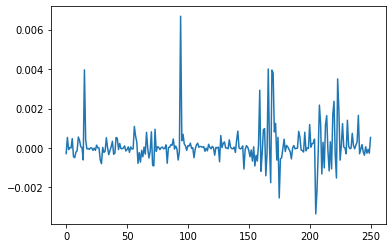

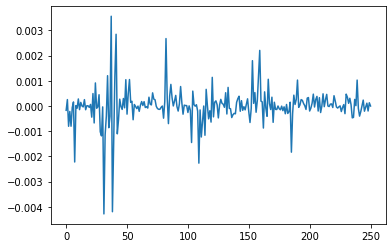

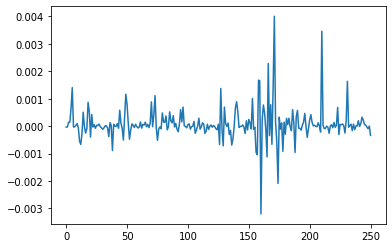

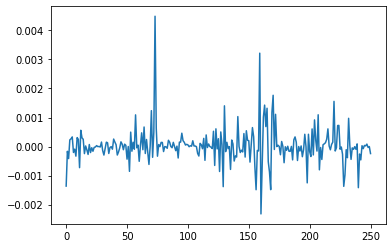

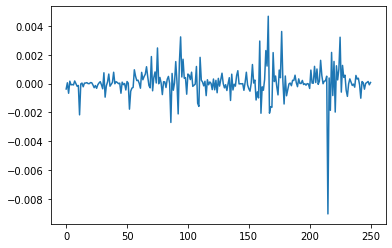

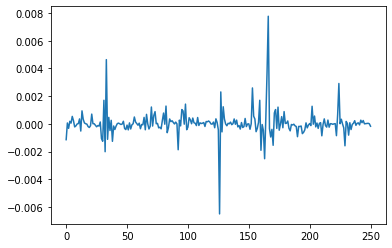

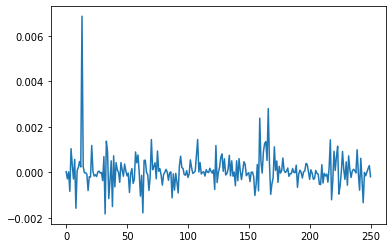

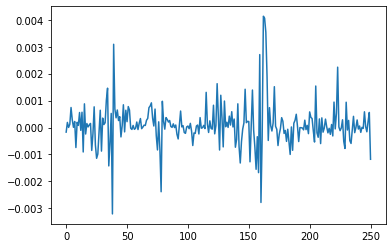

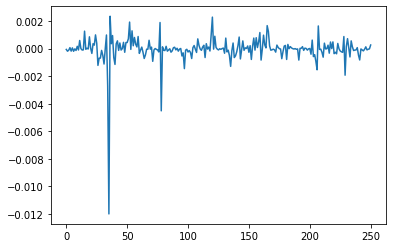

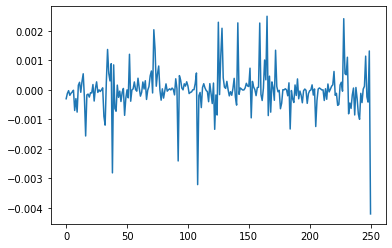

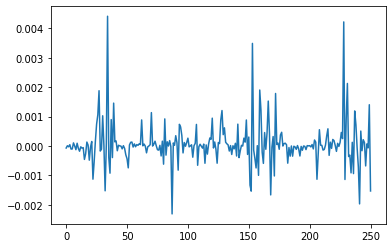

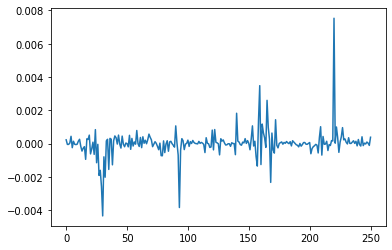

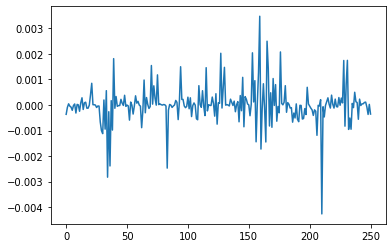

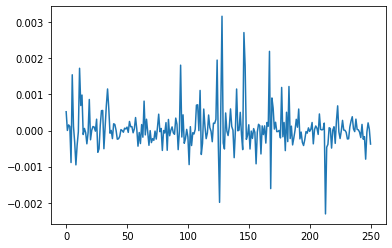

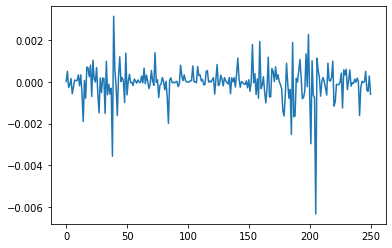

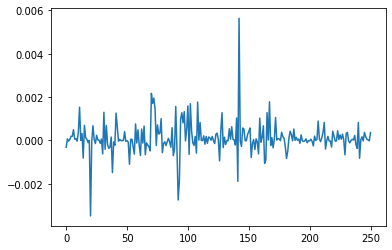

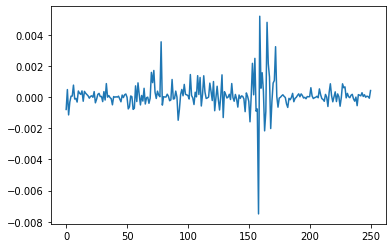

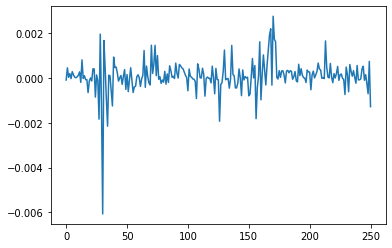

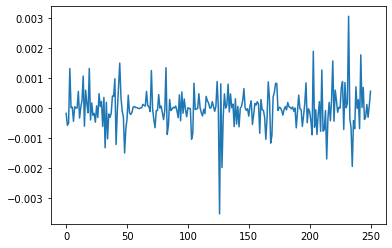

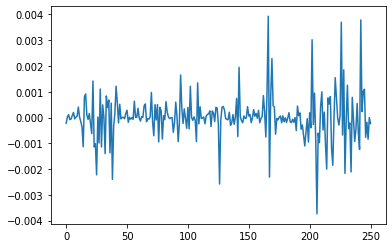

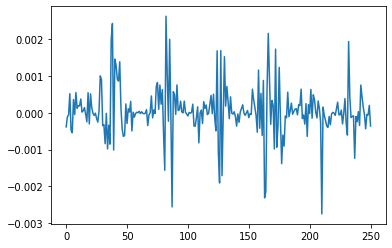

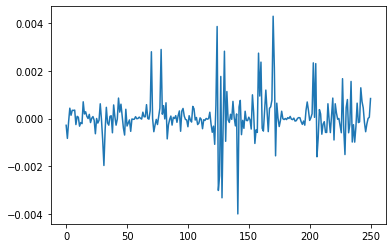

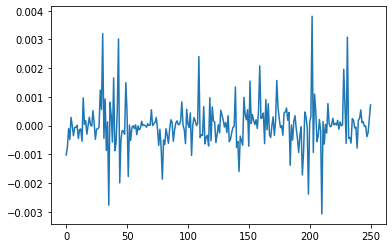

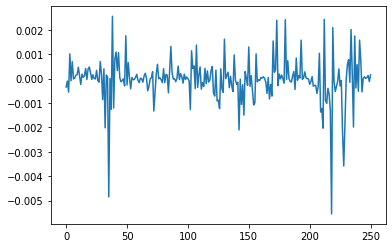

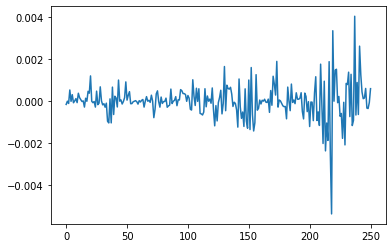

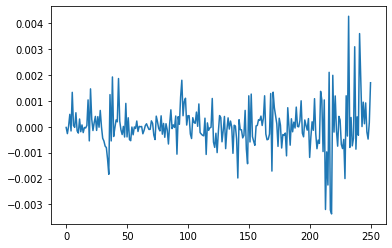

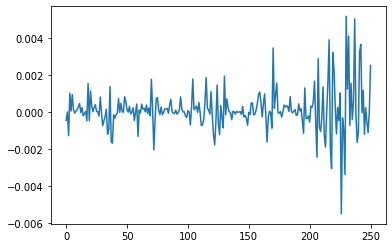

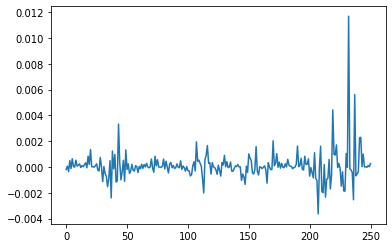

In [114]:
for i in range(55):
    plt.plot(c1[:, i])
    #plt.plot(captured[:, i])
    plt.show()

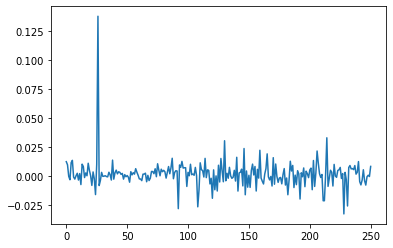

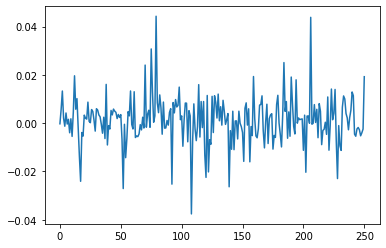

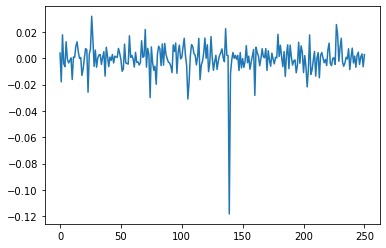

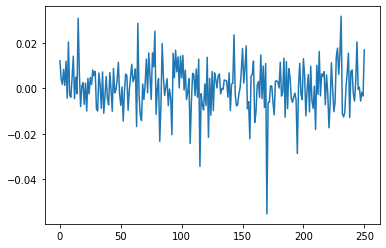

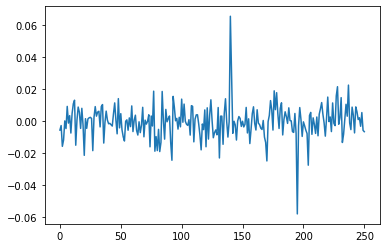

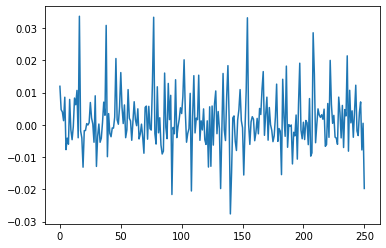

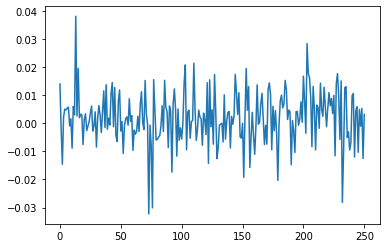

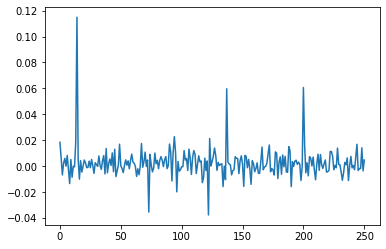

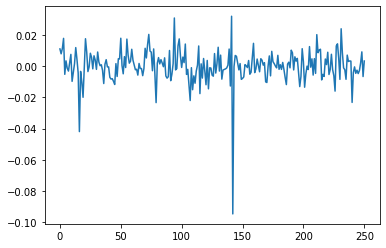

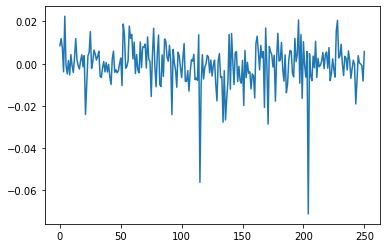

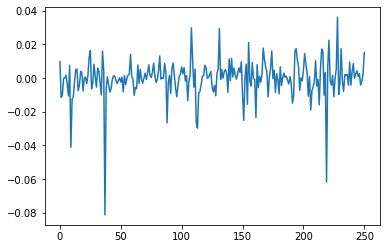

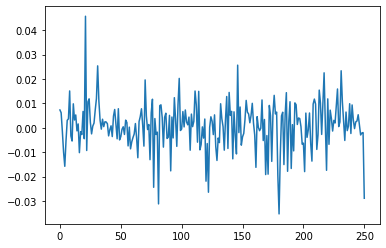

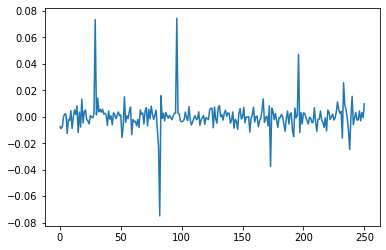

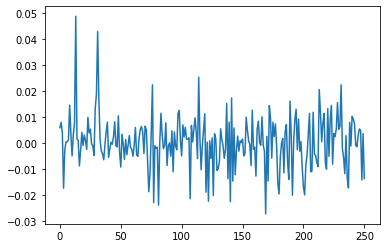

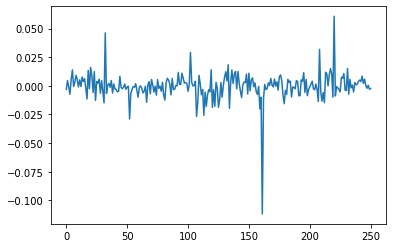

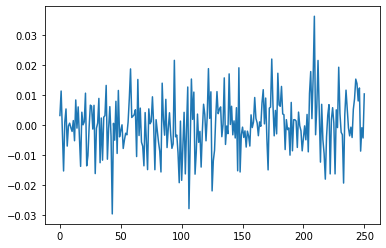

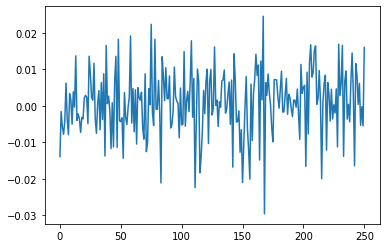

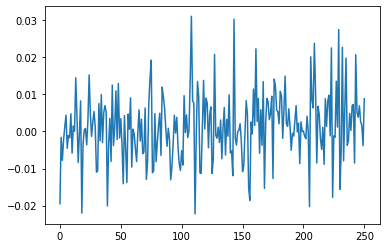

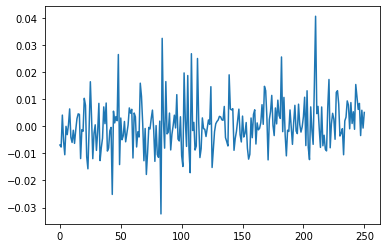

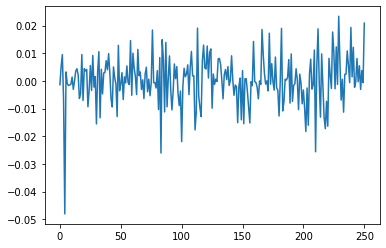

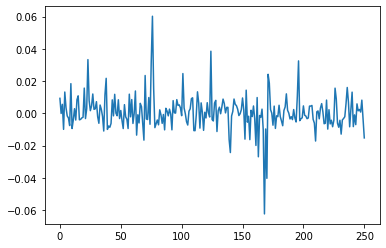

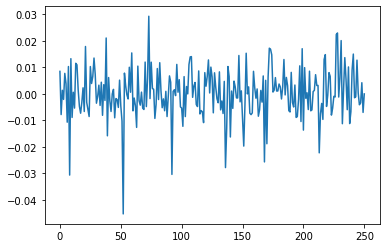

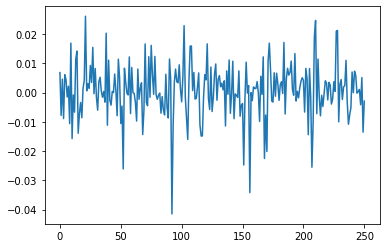

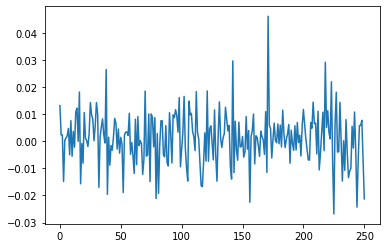

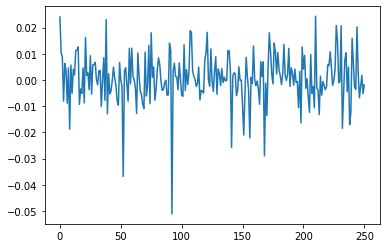

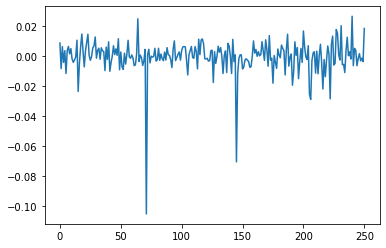

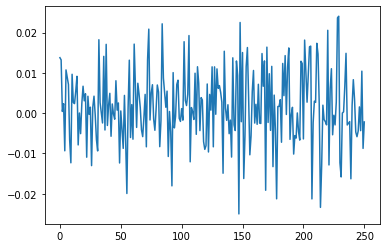

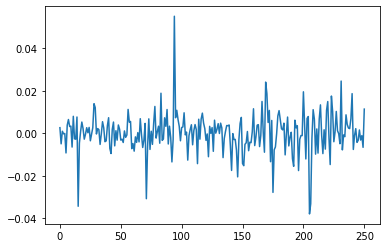

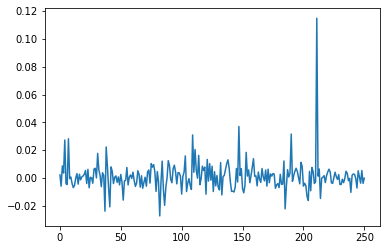

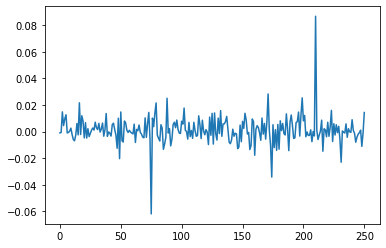

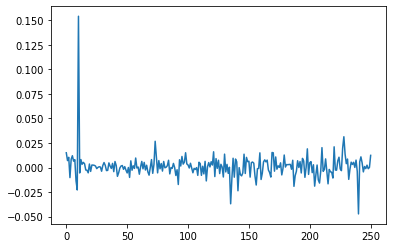

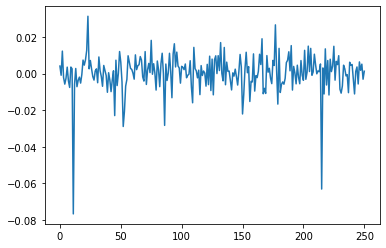

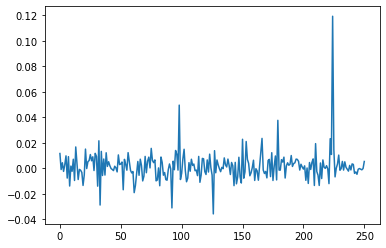

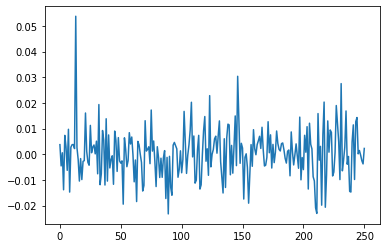

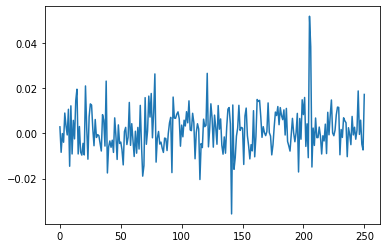

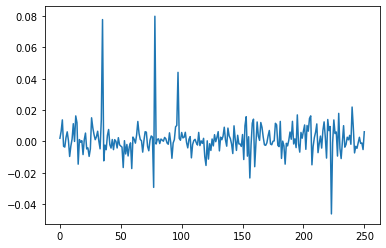

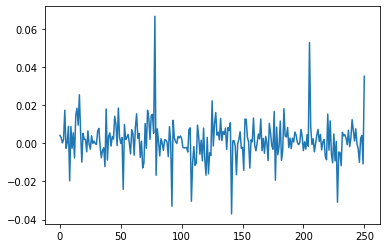

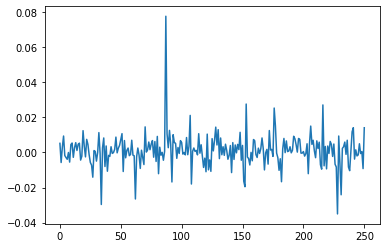

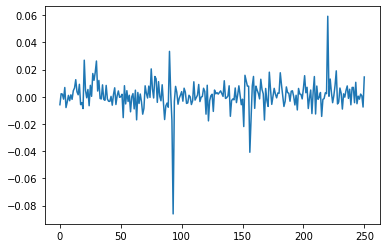

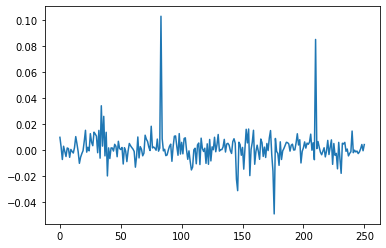

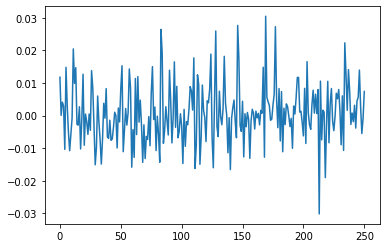

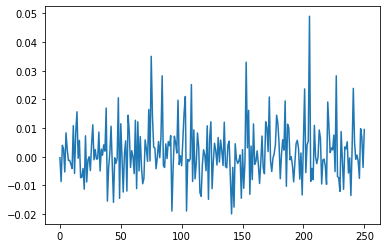

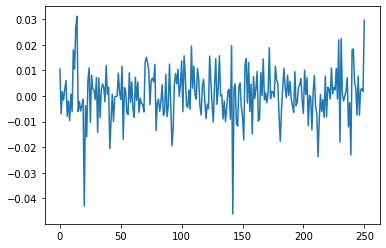

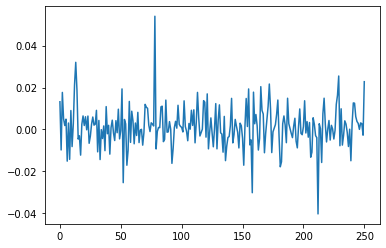

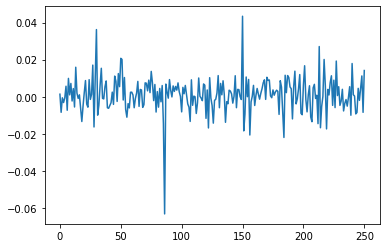

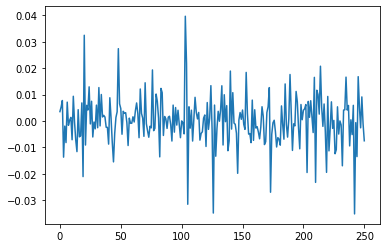

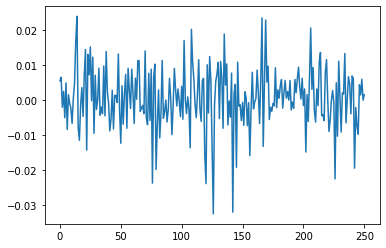

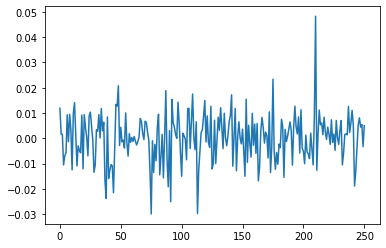

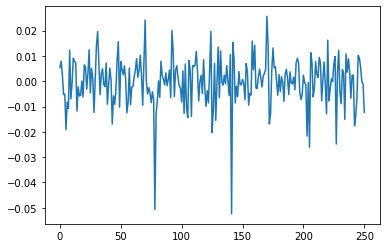

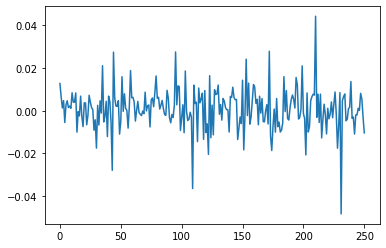

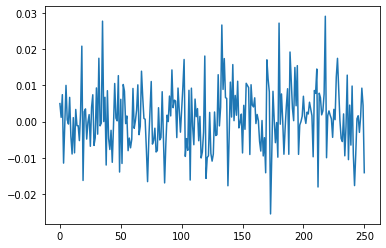

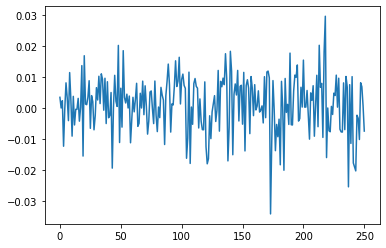

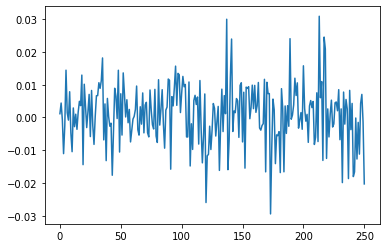

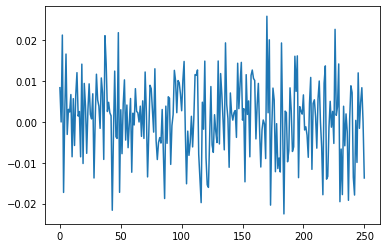

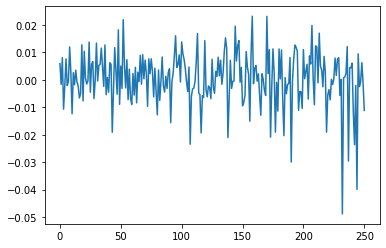

In [115]:
for i in range(55):
    plt.plot(returns[:, i])
    #plt.plot(captured[:, i])
    plt.show()

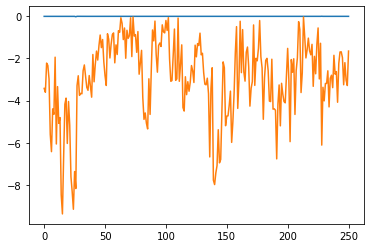

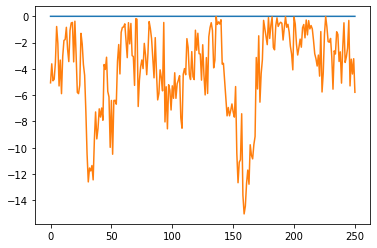

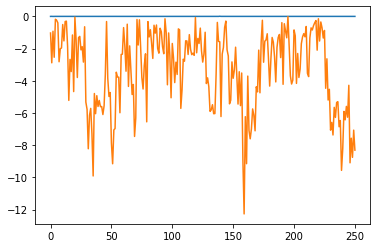

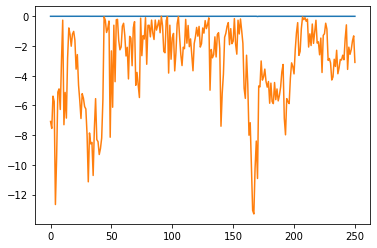

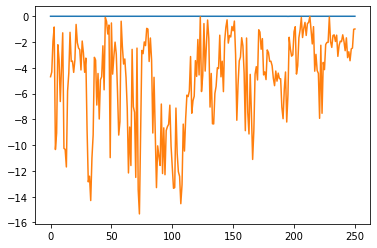

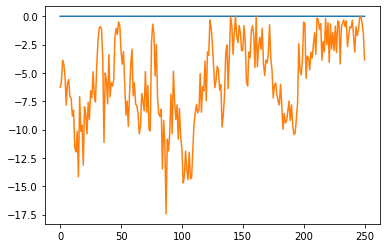

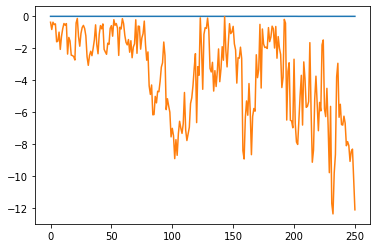

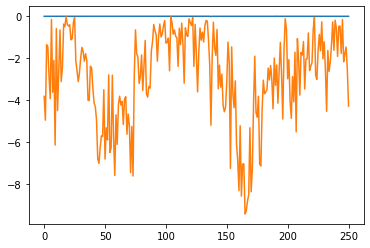

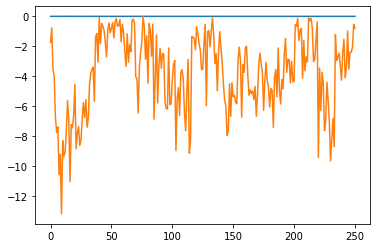

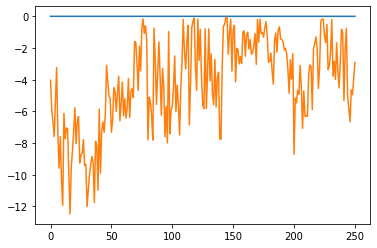

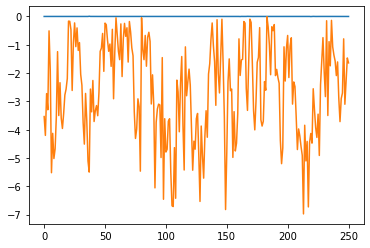

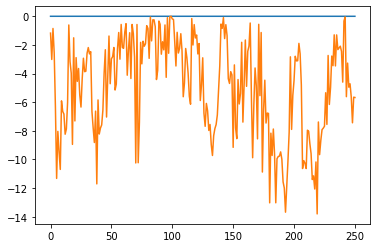

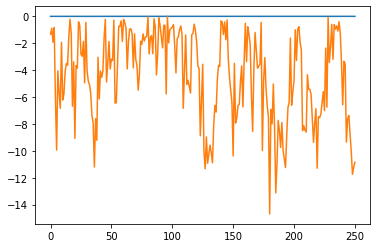

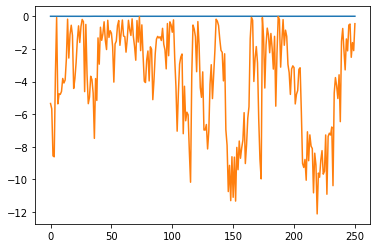

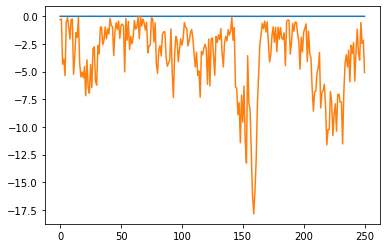

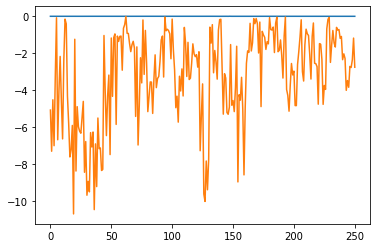

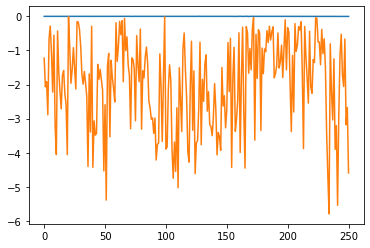

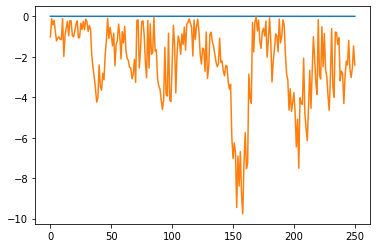

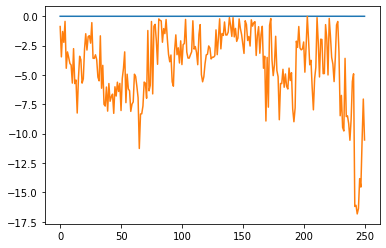

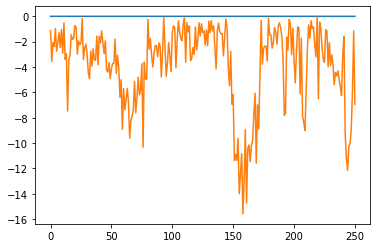

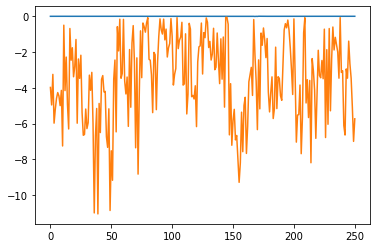

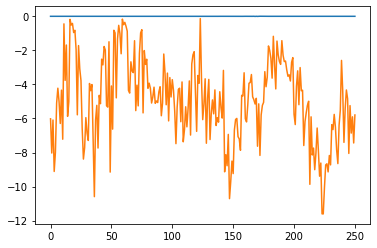

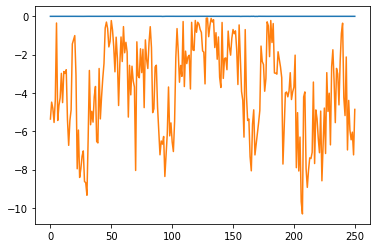

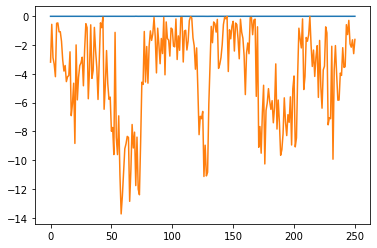

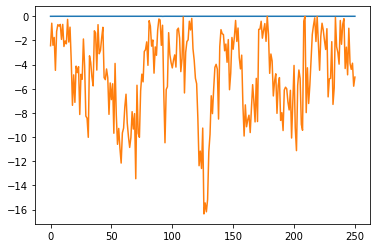

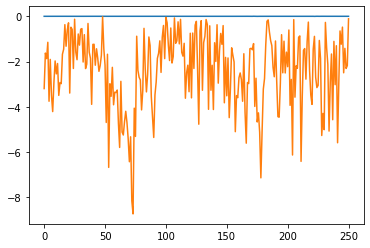

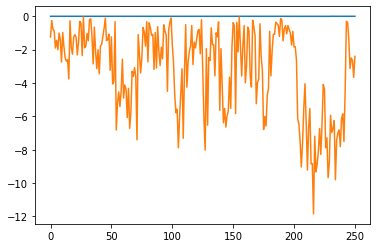

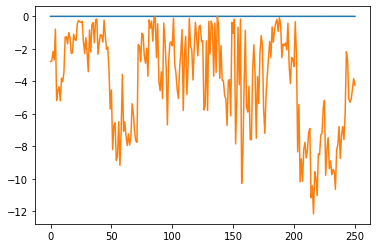

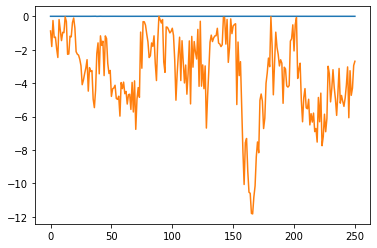

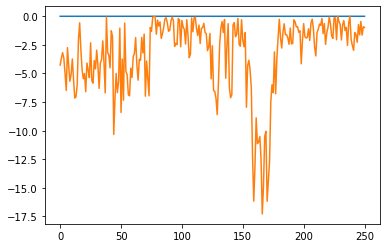

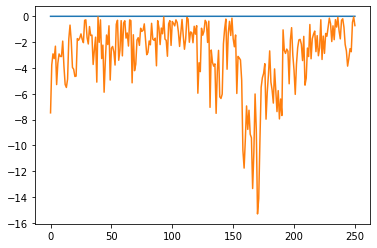

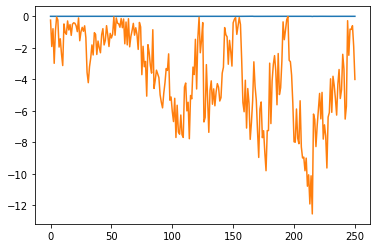

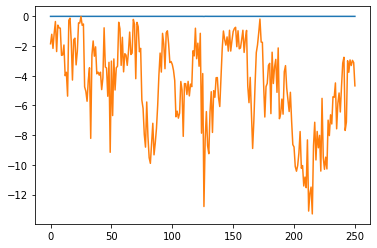

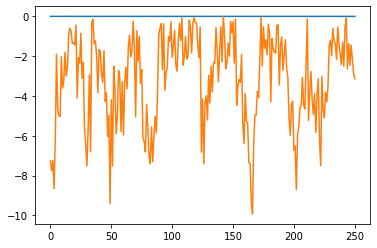

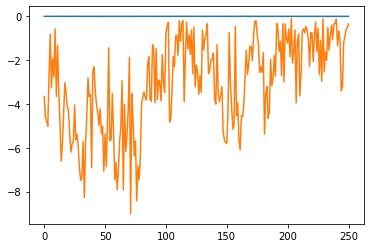

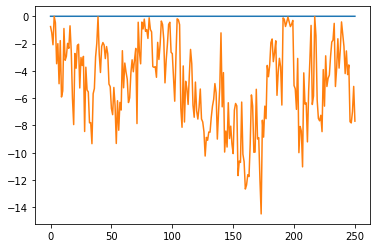

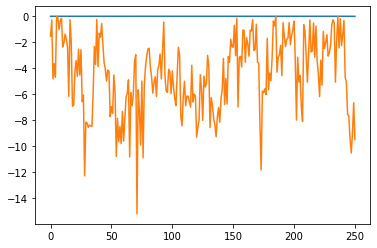

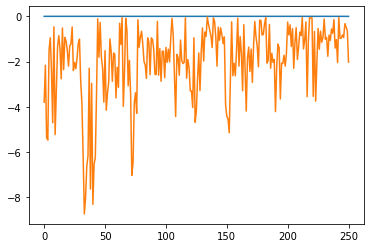

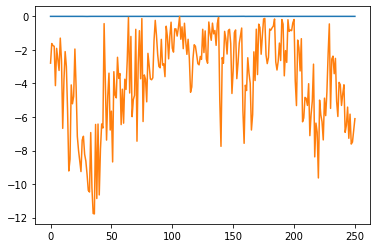

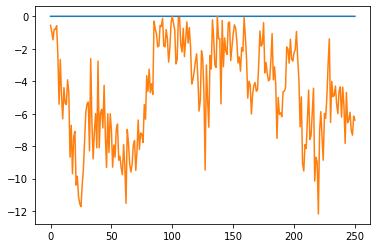

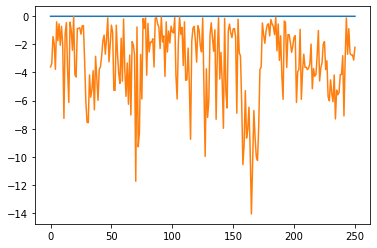

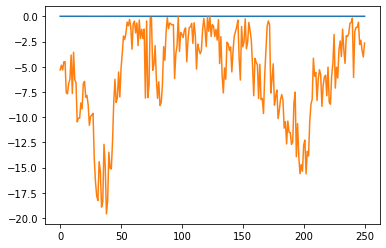

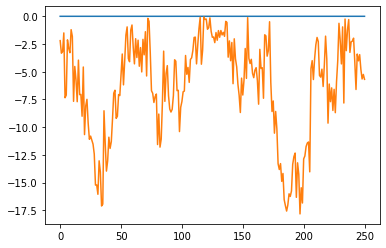

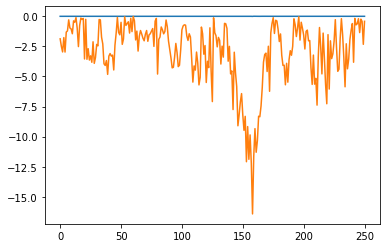

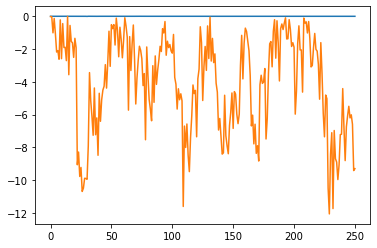

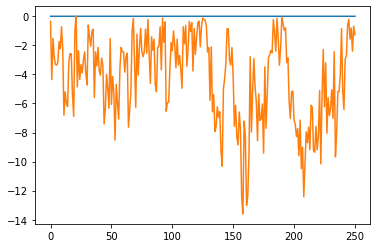

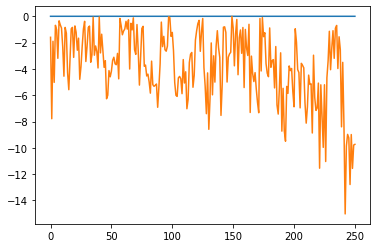

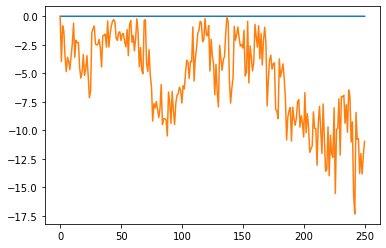

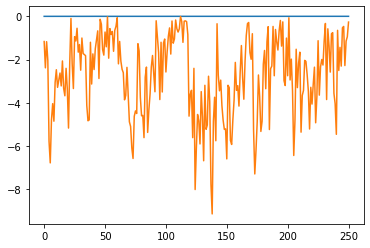

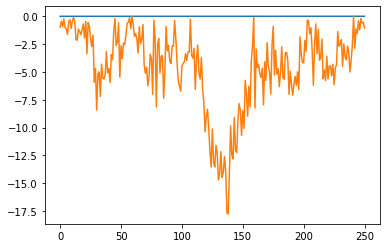

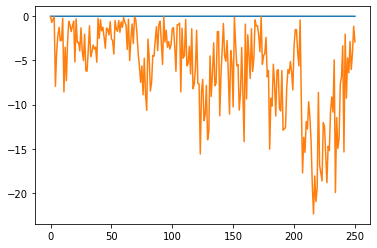

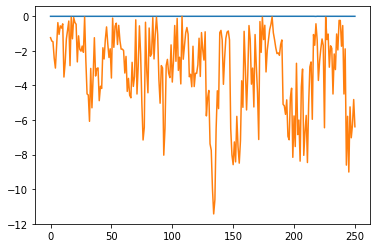

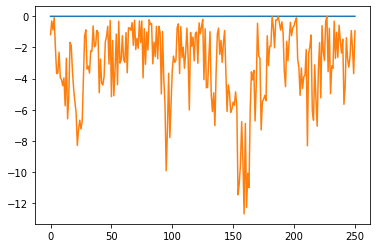

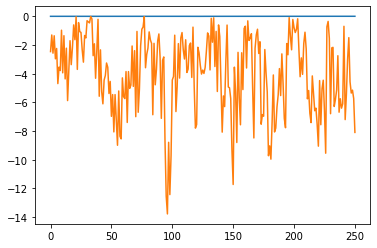

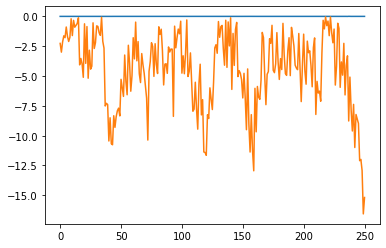

In [112]:
for i in range(55):
    plt.plot(c1[:, i])
    plt.plot(c2[:, i])
    plt.show()

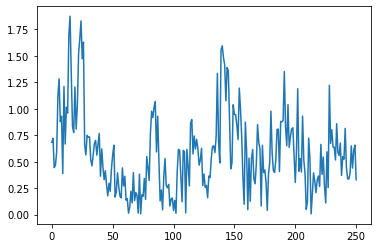

In [106]:
plt.plot(T[:, 0])

In [87]:
sharpes

-89.50003332750113

In [73]:
a = np.array([1, 3])

In [74]:
np.diff(a)

array([2])

In [69]:
sharpes = [sharpe_ratio(captured[:, i]) for i in range(captured.shape[1])]
#sharpes = np.mean(sharpes)

In [70]:
np.mean(sharpes)

0.4030631801523705

In [72]:
sharpes

1.0854162527287072

In [ ]:
T.shape

In [ ]:
captured.shape

In [ ]:
CHECK TURNOVER CALCULATION IN PAPER CODE

In [20]:
with open(os.path.join('results', '{}_seed_{}.pickle'.format(model_type, seed)), 'rb') as f:
    s = pickle.load(f)

In [21]:
s.keys()

dict_keys([Timestamp('2017-01-01 00:00:00', freq='365D'), Timestamp('2018-01-01 00:00:00', freq='365D'), Timestamp('2019-01-01 00:00:00', freq='365D'), Timestamp('2020-01-01 00:00:00', freq='365D'), Timestamp('2020-12-31 00:00:00', freq='365D'), Timestamp('2021-12-31 00:00:00', freq='365D')])

In [22]:
s

{Timestamp('2017-01-01 00:00:00', freq='365D'): {'val': {'preds': array([[-0.06719825, -0.12165906, -0.15836045, ..., -0.02192476,
           -0.05855001, -0.04660154],
          [-0.05941394, -0.09929574, -0.16683619, ..., -0.0629783 ,
           -0.06911193, -0.05740706],
          [-0.03437181, -0.10851533, -0.13773099, ..., -0.0302827 ,
           -0.07600641, -0.05329055],
          ...,
          [-0.06244482, -0.08418113,  0.01842139, ..., -0.07675992,
           -0.1257724 ,  0.00476152],
          [-0.06811493, -0.07323923,  0.00766079, ..., -0.12835382,
           -0.1904522 , -0.03424367],
          [-0.02420451, -0.09484015,  0.01929842, ..., -0.08453773,
           -0.18312718, -0.03283702]], dtype=float32),
   'returns': array([[ 0.01218061, -0.0002563 ,  0.00401444, ...,  0.00114788,
            0.00839684,  0.00594892],
          [ 0.00948089,  0.00570152, -0.01789113, ...,  0.00440326,
            0.        , -0.00164429],
          [-0.0004819 ,  0.01330482,  0.017872

In [24]:
batch_y[0]

tensor([[ 2.5797e-03,  3.7085e-04, -3.2144e-03,  ..., -8.8253e-03,
         -5.5738e-03, -7.6499e-03],
        [-4.4201e-03,  5.9013e-03,  3.8420e-03,  ...,  8.9822e-05,
          5.0745e-03, -2.9620e-03],
        [ 6.8760e-03,  7.9661e-04,  4.4505e-03,  ..., -5.1095e-03,
          2.1016e-03, -3.1893e-03],
        ...,
        [-2.2367e-03, -2.9538e-03, -1.8163e-03,  ..., -9.4694e-03,
          5.8776e-04, -4.8728e-04],
        [ 2.2782e-03, -1.4484e-02,  3.1967e-03,  ...,  4.6133e-04,
         -5.9723e-04,  1.9829e-03],
        [ 7.0853e-02,  3.3031e-03,  1.2235e-02,  ...,  1.5749e-02,
          1.2759e-02,  1.5639e-02]])

In [25]:
batch_y_orig[0]

tensor([[ 0.0045,  0.0007, -0.0058,  ..., -0.0118, -0.0065, -0.0093],
        [-0.0076,  0.0115,  0.0068,  ...,  0.0001,  0.0059, -0.0036],
        [ 0.0117,  0.0015,  0.0078,  ..., -0.0067,  0.0024, -0.0038],
        ...,
        [-0.0033, -0.0052, -0.0029,  ..., -0.0122,  0.0007, -0.0006],
        [ 0.0033, -0.0254,  0.0050,  ...,  0.0006, -0.0007,  0.0022],
        [ 0.1002,  0.0059,  0.0189,  ...,  0.0199,  0.0143,  0.0172]])

In [18]:
results['test']['preds'] = test_preds
results['test']['returns'] = test_returns
results['test']['returns_orig'] = test_returns_orig
results['test']['vols'] = test_vols

In [41]:
T

array([[0.83383634, 0.51192949, 0.28745112, ..., 0.18885391, 1.07419992,
        1.04470401],
       [0.67396717, 0.55053077, 0.53674765, ..., 0.62509811, 0.56359869,
        0.24428089],
       [0.32709056, 0.61189209, 0.3497896 , ..., 0.01410749, 0.66190774,
        0.9456643 ],
       ...,
       [0.87709293, 0.57821921, 0.4666867 , ..., 0.39466517, 0.78080213,
        0.70181444],
       [0.03822577, 0.38370012, 0.83944019, ..., 0.0178256 , 0.54594523,
        0.74240624],
       [0.57244881, 0.2677478 , 0.34134158, ..., 0.32640767, 0.57954612,
        0.71406727]])

In [36]:
batch_x, batch_y, batch_y_orig, batch_vol = next(iter(train_loader))

In [37]:
batch_x.shape, batch_vol.shape

(torch.Size([64, 21, 440]), torch.Size([64, 21, 55]))

In [38]:
batch_x.max()

tensor(5.8374)

In [39]:
batch_x.min()

tensor(-5.7343)

In [40]:
batch_y.shape, batch_y_orig.shape

(torch.Size([64, 21, 55]), torch.Size([64, 21, 55]))

In [69]:
#model = LSTMnet(batch_x.shape[2], batch_y.shape[2], batch_x.shape[1])
#model = SLP(batch_x.shape[2], batch_y.shape[2], batch_x.shape[1])
#model = MLP(batch_x.shape[2], batch_y.shape[2], batch_x.shape[1])
model = TCN(batch_x.shape[2], batch_y.shape[2], batch_x.shape[1], 5)

In [ ]:
val_preds = []
val_returns = []
val_returns_orig = []
val_vols = []

model.eval()

with torch.no_grad():
    for batch_x, batch_y, batch_y_orig, batch_vol in val_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        batch_y_orig = batch_y_orig.to(device)
        batch_vol = batch_vol.to(device)

        output = model(batch_x)


        # select last timestep as we no longer need for time axis in batch
        val_returns.append(batch_y[:, -1, :].detach().cpu().numpy())
        val_returns_orig.append(batch_y[:, -1, :].detach().cpu().numpy())
        val_preds.append(output[:, -1, :].detach().cpu().numpy())
        val_vols.append(batch_vol[:, -1, :].detach().cpu().numpy())


val_preds = np.concatenate(val_preds)
val_returns = np.concatenate(val_returns)
val_returns_orig = np.concatenate(val_returns_orig)
val_vols = np.concatenate(val_vols)

In [ ]:
test_preds = []
test_returns = []
test_returns_orig = []
test_vols = []

with torch.no_grad():
    for batch_x, batch_y, batch_y_orig, batch_vol in test_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        batch_y_orig = batch_y_orig.to(device)
        batch_vol = batch_vol.to(device)

        output = model(batch_x)


        # select last timestep as we no longer need for time axis in batch
        test_returns.append(batch_y[:, -1, :].detach().cpu().numpy())
        test_returns_orig.append(batch_y[:, -1, :].detach().cpu().numpy())
        test_preds.append(output[:, -1, :].detach().cpu().numpy())
        test_vols.append(batch_vol[:, -1, :].detach().cpu().numpy())


test_preds = np.concatenate(test_preds)
test_returns = np.concatenate(test_returns)
test_returns_orig = np.concatenate(test_returns_orig)
test_vols = np.concatenate(test_vols)

